# Car_Price

&nbsp;

#### 최재혁

---

## 목차

1. 패키지 불러오기

2. 결측치 

3. 아웃라이어

4. Standard Scaler 적용
 
5. OLS

6. 평가

---

# 1. 패키지 불러오기

In [165]:
%matplotlib inline

In [166]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.experimental import enable_iterative_imputer
from statsmodels.stats.stattools import jarque_bera
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
import warnings
from matplotlib import rc
from sklearn import metrics
warnings.filterwarnings('ignore')
sns.set_palette("pastel")

In [167]:
# 한글 폰트 사용을 위해서 세팅
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

&nbsp;

## 데이터 불러오기

In [168]:
vihicle_data = pd.read_csv('vehicle_dataset.csv')

In [169]:
vihicle_data.describe()

Price      Mileage      EngineV         Year
count    4173.000000  4345.000000  4195.000000  4345.000000
mean    19418.746935   161.237284     2.790734  2006.550058
std     25584.242620   105.705797     5.066437     6.719097
min       600.000000     0.000000     0.600000  1969.000000
25%      6999.000000    86.000000     1.800000  2003.000000
50%     11500.000000   155.000000     2.200000  2008.000000
75%     21700.000000   230.000000     3.000000  2012.000000
max    300000.000000   980.000000    99.990000  2016.000000

In [170]:
vihicle_data.columns

Index(['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'Model'],
      dtype='object')

In [171]:
vihicle_data['Brand'].unique()

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

&nbsp;

## 이름 간소화

In [172]:
new_brand = []

for i in vihicle_data['Brand']:
    if(i == 'Mercedes-Benz'):
        new_brand.append(i.split('-')[1])
    else:
        new_brand.append(i)

In [173]:
vihicle_data['Brand'] = new_brand

In [174]:
vihicle_data['Brand'].unique()

array(['BMW', 'Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

---

# 2. 결측치

In [175]:
nan_count = 0
for i in vihicle_data.isna().sum():
    nan_count+=i

print(nan_count/vihicle_data.shape[0] * 100)

7.410817031070195


#### 전체의 7% 만 결측치

&nbsp;

## 2-1. 결측치 확인 및 분석

In [176]:
total = vihicle_data.isnull().sum().sort_values(ascending=False)

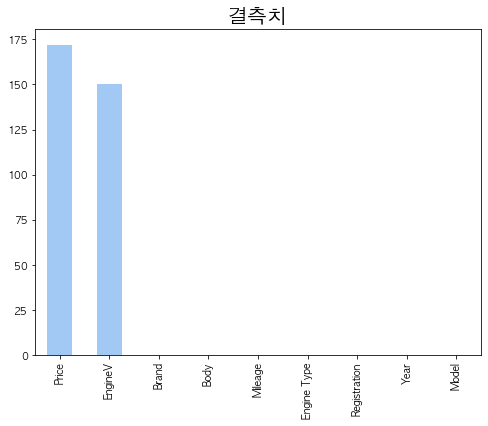

In [177]:
total.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 10)
plt.ylabel("", fontsize = 10)
plt.title("결측치", fontsize = 20)

plt.show()

#### 전체 데이터중 Prcie와 EngineV에만 결측치가 존제

&nbsp;

## 2-2. 전체의 상관관계 및 전체에서 결측치를 제외한 상관관계 확인

In [178]:
nan_none_data = vihicle_data.loc[(vihicle_data['Price'].isna() != True) & (vihicle_data['EngineV'].isna() != True)]

In [179]:
nan_data = vihicle_data.loc[(vihicle_data['Price'].isna() == True) | (vihicle_data['EngineV'].isna() == True)]

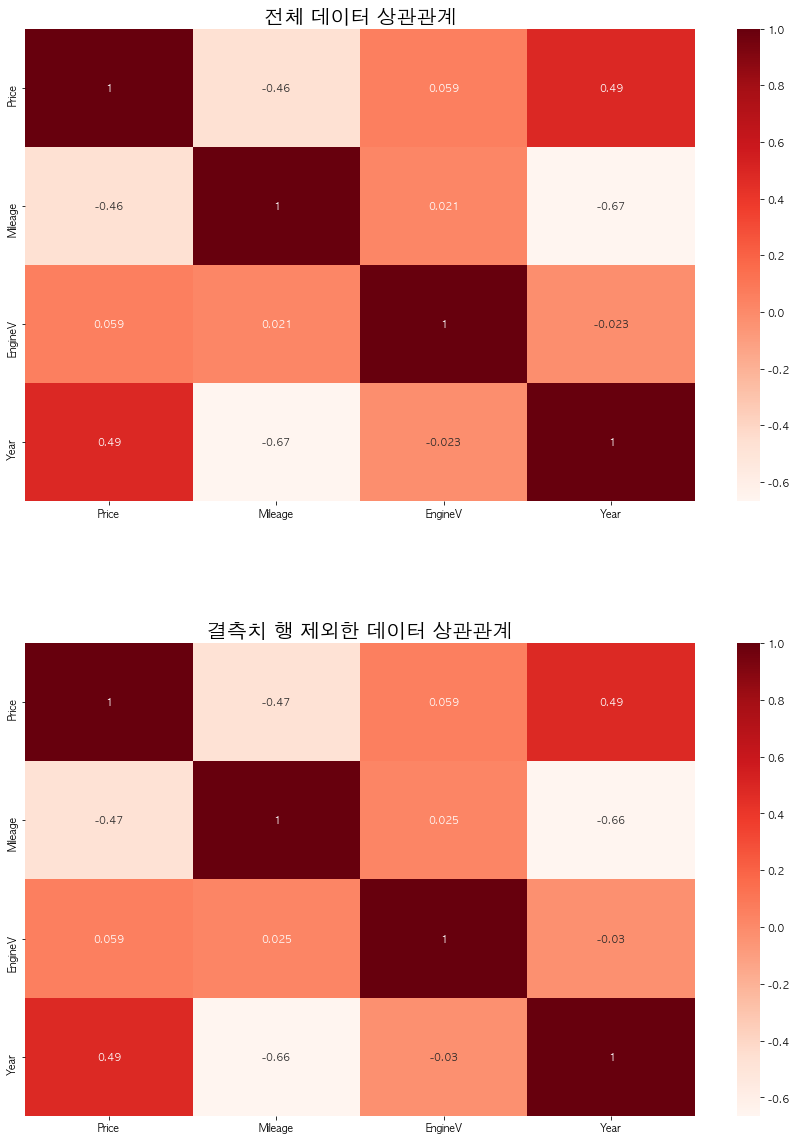

In [192]:
fig, axes = plt.subplots(2,figsize=(15, 20))
plt.subplots_adjust(wspace=0.2, hspace = 0.3)

all_data = sns.heatmap(vihicle_data.corr(),annot=True, ax=axes[0],cmap='Reds')
all_data.set_title('전체 데이터 상관관계',fontsize=20)

all_data_2 = sns.heatmap(nan_none_data.corr(),annot=True, ax=axes[1],cmap='Reds')
all_data_2.set_title('결측치 행 제외한 데이터 상관관계',fontsize=20)


plt.show()

#### 전체데이터와 결측치를 제외한 데이터 사이의 큰차이는 없으며
#### Price와 Year의 상관관계가 크게 파악됨

&nbsp;

## 2-3. 결측치 데이터, Price가 결측치 일때,EngineV가 결측치일때 나머지 열의 상관관계

In [193]:
na_price = nan_data.loc[nan_data['Price'].isna() == True]
na_enginev = nan_data.loc[nan_data['EngineV'].isna() == True]

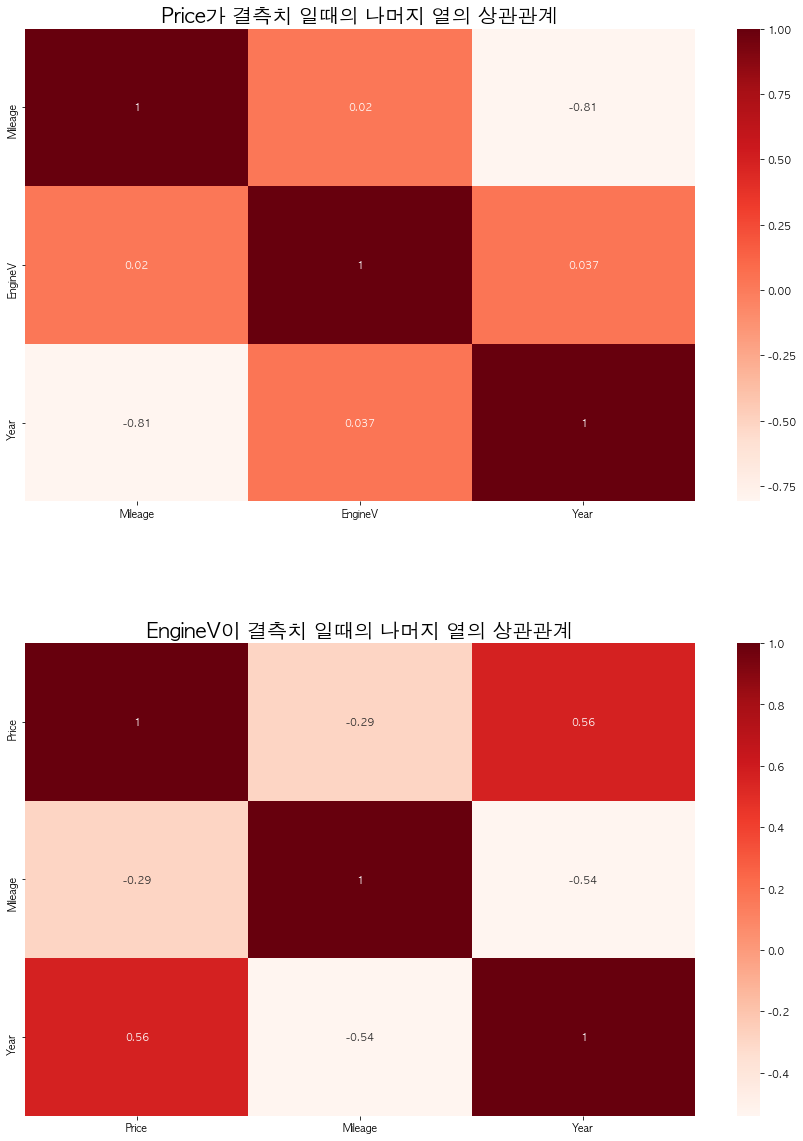

In [194]:
fig, axes = plt.subplots(2,figsize=(15, 20))
plt.subplots_adjust(wspace=0.2, hspace = 0.3)

nan_price_data = sns.heatmap(na_price.loc[:,na_price.columns != 'Price'].corr(),annot=True, ax=axes[0],cmap='Reds')
nan_price_data.set_title('Price가 결측치 일때의 나머지 열의 상관관계',fontsize=20)

nan_enginv_data = sns.heatmap(na_enginev.loc[:,na_enginev.columns != 'EngineV'].corr(),annot=True, ax=axes[1],cmap='Reds')
nan_enginv_data.set_title('EngineV이 결측치 일때의 나머지 열의 상관관계',fontsize=20)


plt.show()

#### 결측치가 있을때의 데이터와 없을때의 데이터 사이의 큰차이는 없음

&nbsp;

## 2-4. 전체 데이터에서 Price와 Year 사이의 그래프 확인

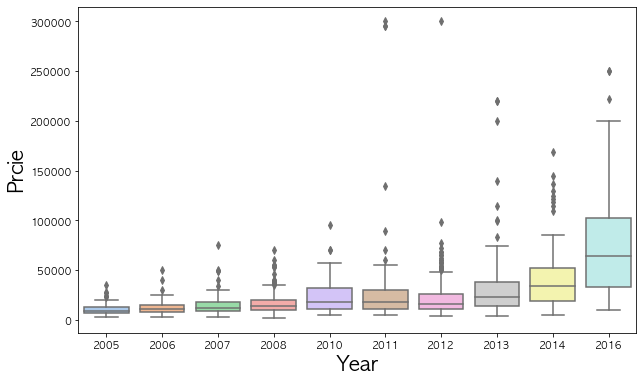

In [195]:
# 상위 10개의 연도만 남겨서 그때의 Price값 확인
top_list = vihicle_data['Year'].value_counts().nlargest(10).index
df_top = vihicle_data[vihicle_data['Year'].isin(top_list)]


plt.figure(figsize=(10,6))
box=sns.boxplot(y='Price',x='Year',data=df_top)
box.set_xlabel("Year",fontsize=20)
box.set_ylabel("Prcie",fontsize=20)
plt.show()

#### 연도가 높아질수록 값또한 높아지는 경향을 확인할수 있다.

&nbsp;

## 2-5. 전체 데이터의 수치형 데이터의 분포 확인

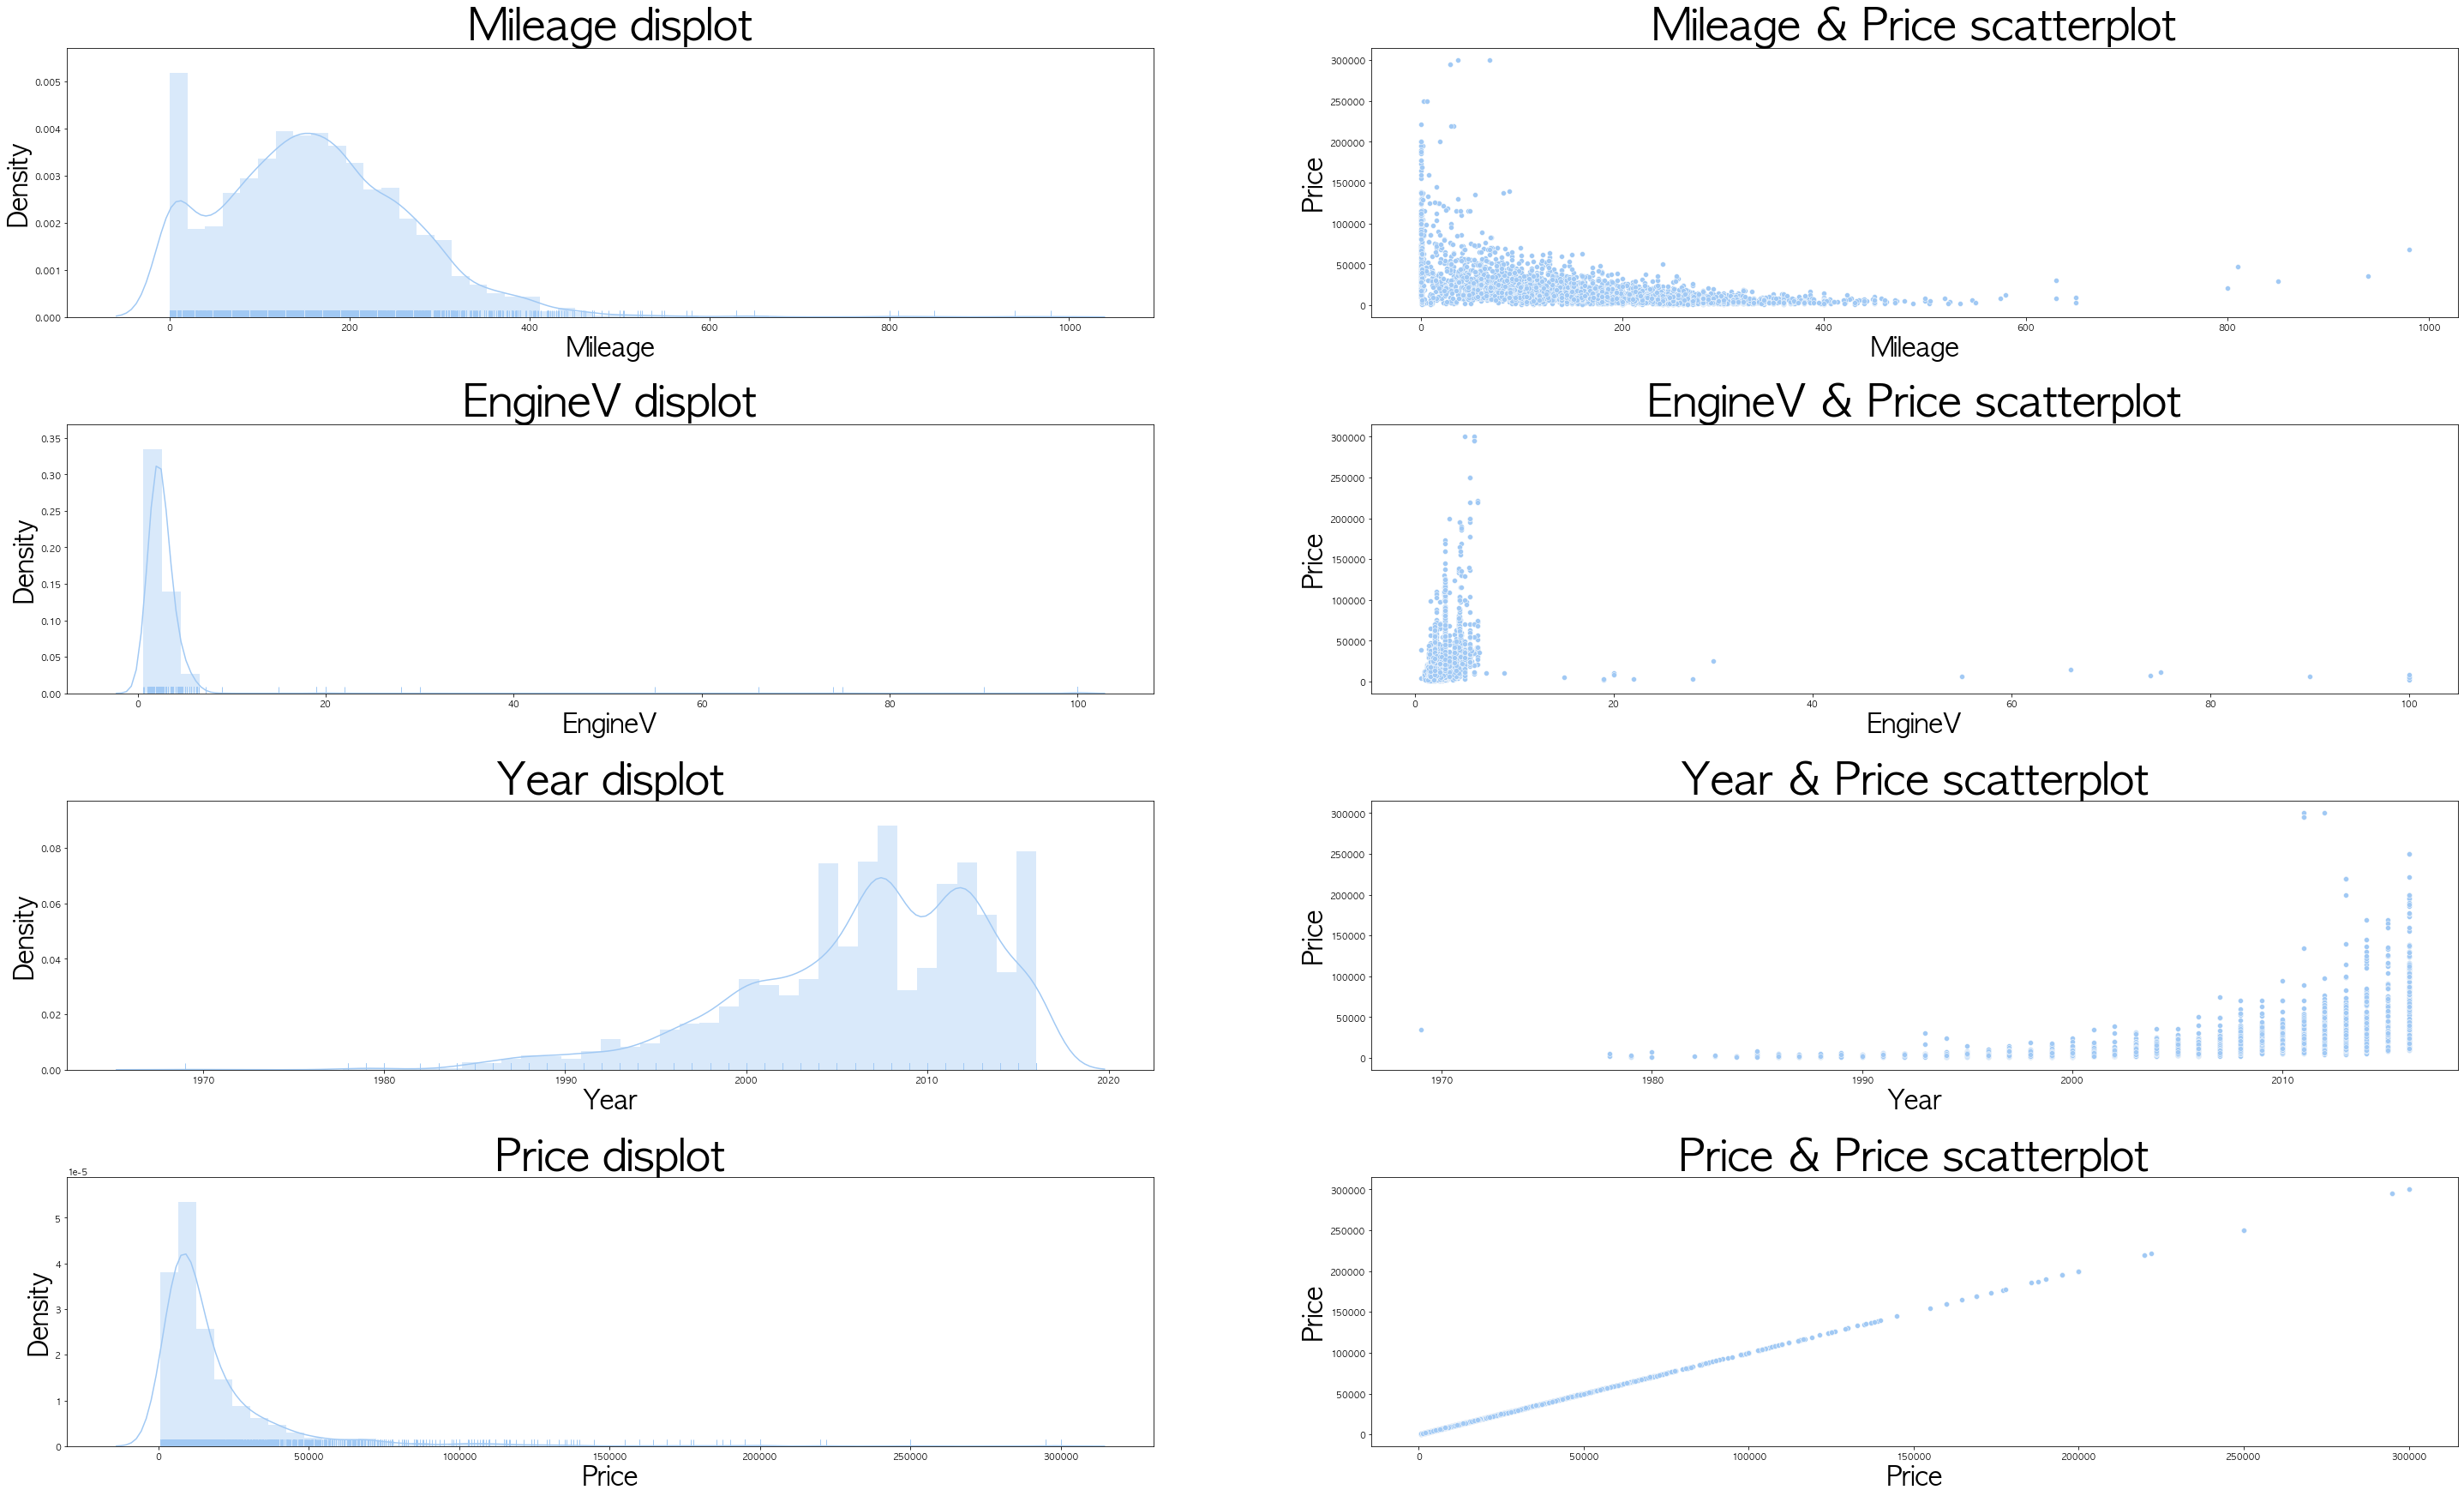

In [196]:
fig, axes = plt.subplots(4,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Year','Price']

count = 0 
for i in range(len(name_list)):
    
    globals()['b{}'.format(i)] =  sns.distplot(vihicle_data[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = vihicle_data,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

#### displot에서 각열이 한쪽으로 치우쳐진 경향을 볼수있고
#### Scatterplot을 통해서 year을 제외한 나머지 데이터는 Price와의 상관관계가 낮은 걸 확인할수 있습니다.

&nbsp;

## 2-6. 전체데이터의 범주형 데이터 분포 확인

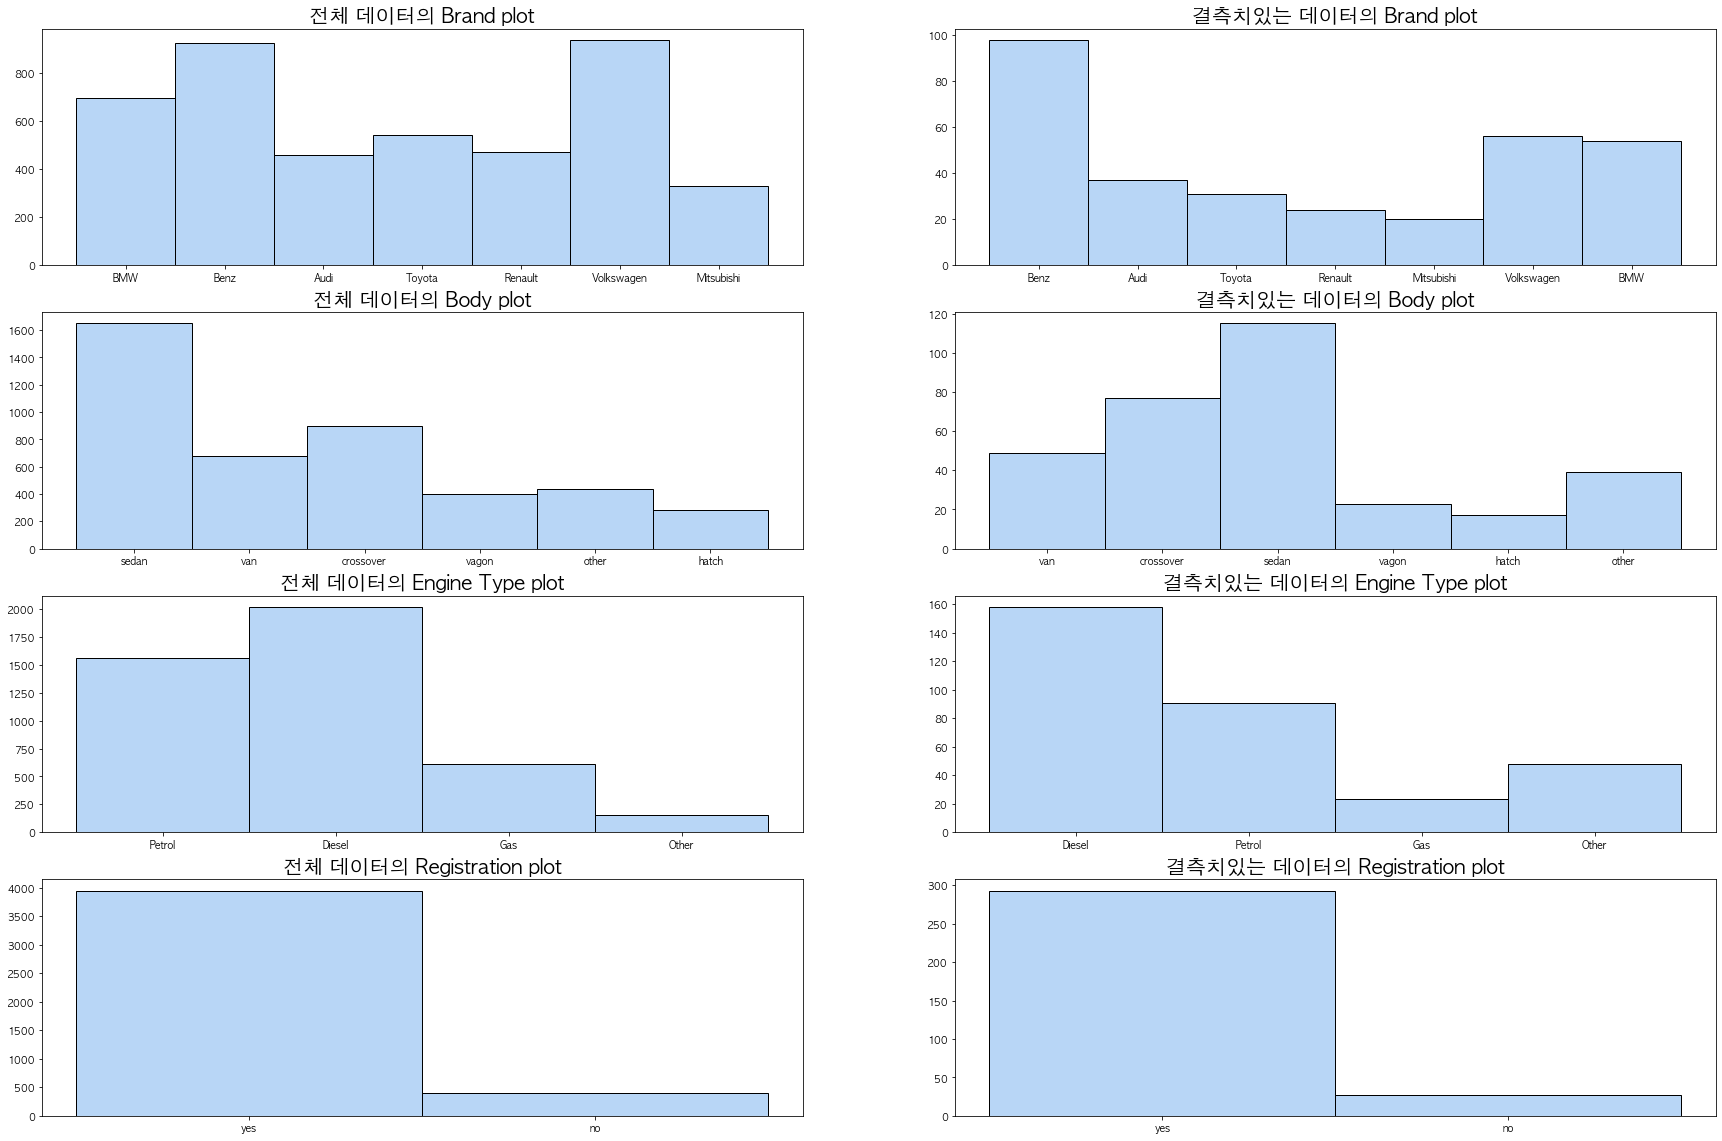

In [197]:
fig, axes = plt.subplots(4,2,figsize=(30, 20))
plt.subplots_adjust(wspace=0.2, hspace = 0.2)

null_ever = ['Brand','Body','Engine Type','Registration']

for d,i in enumerate(null_ever):
    globals()['n{}'.format(d)] = sns.histplot(vihicle_data[i],ax=axes[d,0], palette='pastel')
    globals()['n{}'.format(d)].set_xlabel('')
    globals()['n{}'.format(d)].set_ylabel('')
    globals()['n{}'.format(d)].set_title('전체 데이터의'+ ' '+ i + ' ' + 'plot',fontsize=20)
    
    globals()['m{}'.format(d)] = sns.histplot(nan_data[i],ax=axes[d,1], palette='pastel')
    globals()['m{}'.format(d)].set_xlabel('')
    globals()['m{}'.format(d)].set_ylabel('')
    globals()['m{}'.format(d)].set_title('결측치있는 데이터의'+' '+i+ ' ' + 'plot',fontsize=20)
    
plt.show()

&nbsp;

## 2-7. model이 너무 많아서 상위 10개만 시각화

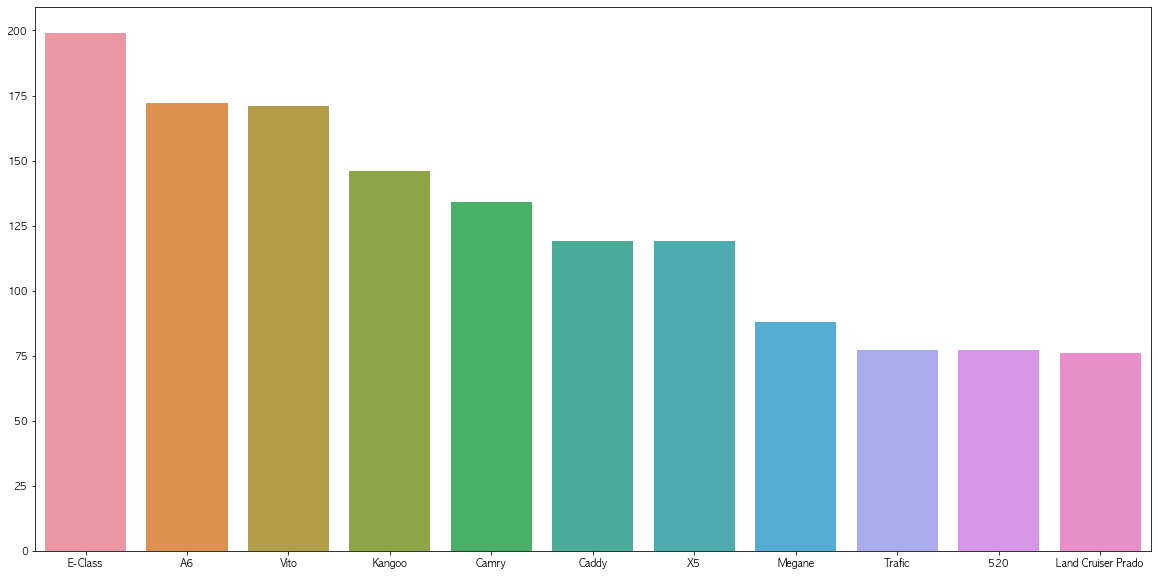

In [198]:
fig, axes = plt.subplots(figsize=(20, 10))
model_value = {vihicle_data['Model'].value_counts().index[i] : d for i,d in enumerate(vihicle_data['Model'].value_counts()) if i<=10}
model_values = pd.DataFrame([model_value])
sns.barplot(data=model_values)
plt.show()

&nbsp;

#### 전체 데이터랑 비교했을때 Price,EngineV가 결측치일경우 
#### Brnad는 Benz , Body는 seadan, Engine Type은 Diesel, Registraion은 Yes가 높은걸 확인할수 있고

#### 높은 항목들이 전체 데이터의 분포와 비슷하다는 것을 알수있었습니다.

&nbsp;

## 2-8. 결측치 대체방법

##### get_dummies를 먼저 수행

In [199]:
# 범주형 변수의 변환
# 범주 개수가 N이면 N개 모두 사용시 선형 종속 발생
# N-1개를 사용하기 위해 drop_first 이용
# AAA B 같은 학습영향 줄이기 위해

vihicle_data_dummi=pd.get_dummies(vihicle_data,columns=['Year','Brand','Body','Engine Type','Registration','Model'],drop_first=True)

&nbsp;

#### 1.dropna() 방식
#### 2.simpleimputer 방식
#### 3.IterativeImputer 방식

#### 나눠서 진행시킬예정

&nbsp;

In [200]:
drop_dummi = vihicle_data_dummi.copy()
simple_dummi = vihicle_data_dummi.copy()
itera_dummy = vihicle_data_dummi.copy()

&nbsp;

## dropna 방식

In [201]:
non_missing_df = drop_dummi.dropna().copy()

&nbsp;

## simpleimputer 방식

In [202]:
ipt = SimpleImputer(missing_values=np.nan, strategy='mean')

ipt = ipt.fit(simple_dummi[['Price','EngineV']].values)
train_n = ipt.transform(simple_dummi[['Price','EngineV']].values)

In [203]:
simple_dummi['Price'] = train_n[:,0]
simple_dummi['EngineV'] = train_n[:,1]

&nbsp;

## IterativeImputer 방식

In [204]:
test_statistic = pd.DataFrame(IterativeImputer(verbose=True,random_state=123,max_iter=100).fit_transform(itera_dummy))


itera_dummy['Price'] = test_statistic[0]
itera_dummy['EngineV']  = test_statistic[2]

[IterativeImputer] Completing matrix with shape (4345, 367)
[IterativeImputer] Change: 213462.65441804784, scaled tolerance: 300.0 
[IterativeImputer] Change: 37.6686564460706, scaled tolerance: 300.0 
[IterativeImputer] Early stopping criterion reached.


&nbsp;

### IterativeImputer 설명

### 참고논문 
https://www.jstatsoft.org/article/view/v045i03

요약 : IterativeImputer은 사용 가능한 특성 차원의 전체 세트를 사용하여 누락 된 값을 추정합니다

&nbsp;

### IterativeImputer 과정

1. 누락된 값이있는 각 열을 다른 열의 값으로 모델링하고 해당 추정치를 대치에 사용 
2. 각 단계에서 특성 열은 출력 y 로 지정되고 다른 특성 열은 입력 X 로 처리 
3. 회귀 변수는 알려진 y 에 대해 (X, y) 에 적합 
4. 그런 다음 회귀 변수를 사용하여 y의 결측값을 예측
5. 각 기능에 대해 반복적 인 방식으로 수행 된 다음 max_iter 만큼 반복됩니다 
6. 최종 라운드에 결과가 반환됩니다

&nbsp;

찾아보고 알아본점 
 - 아직 실험적인 방법이라는 설명이 많음
 - 실질적으로 사용방법에 k-fold와 같은 검증을 거치고 사용하고 판단을 해야하는 과정의 복잡성이 큼

&nbsp;

## 2-9. 결측치 대체후 데이터 상관관계 확인

#### - dropna

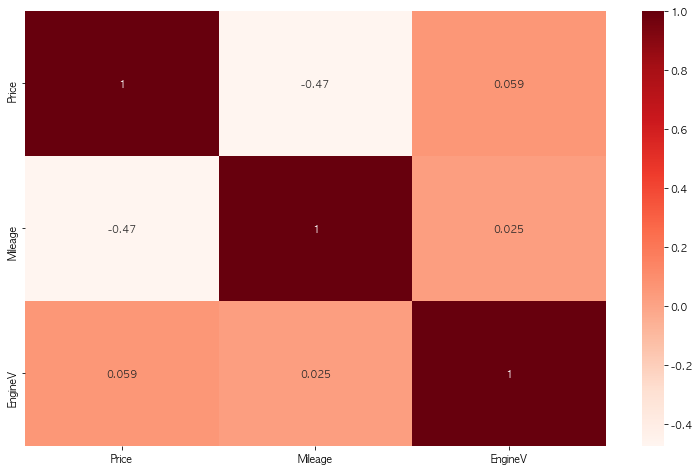

In [205]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(non_missing_df[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### - simpleimputer

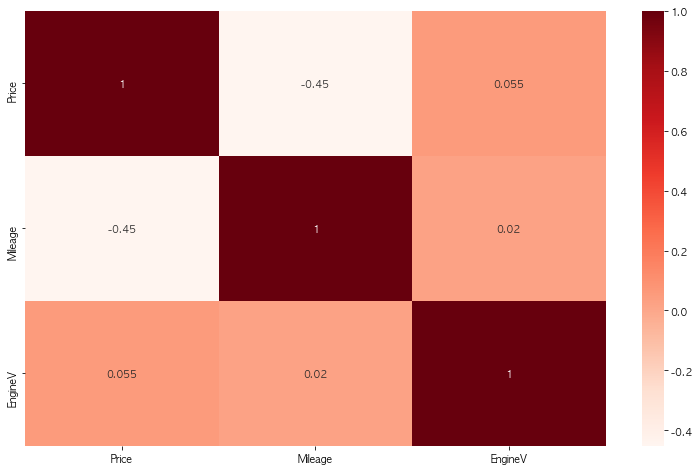

In [206]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(simple_dummi[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### - IterativeImputer

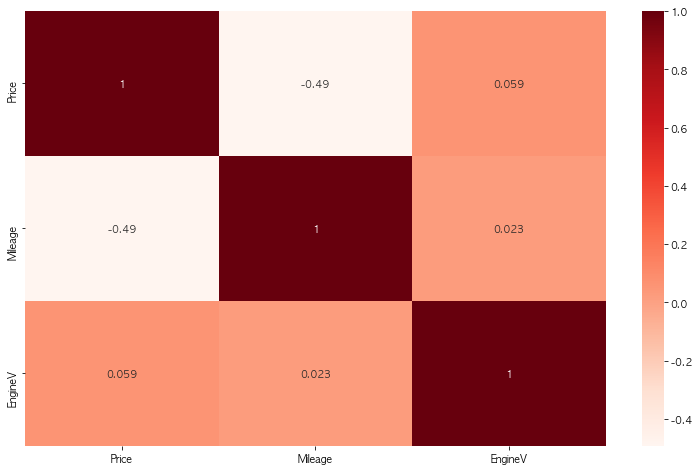

In [207]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(itera_dummy[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

---

# 3. outlier

### - outlier을 99% 0.01에서 제거하기

#### 수치형 데이터는 'Price','Mileage','EngineV'
##### z-score 99% 기준 z값 2.58
##### 99% 기준 값 사이는 -2.58<  <2.58
#### year 같은 경우에 수치형이라고 보기 어려워서 Price,Mileage,EngineV 중
#### Price와 상관관계 순서대로 outlier 제거를 수행할예정
#### 순서는 Price,EngineV,Milleage 순으로 outlier 제거를 수행

&nbsp;

In [208]:
def outlier_99(df,column):
    mean = np.mean(df[column])
    std = np.std(df[column])
    
    non_outlier = []
    outlier = []
    for d,i in enumerate(df[column]):
        z = (i-mean)/std
        if(z < 2.58 and z>-2.58):
            non_outlier.append(d)
        else:
            outlier.append(d)
    print(column + '의 outlier 갯수는:', len(outlier))
    
    return outlier

&nbsp;

#### - dropna 방식

In [209]:
non_missing_df = non_missing_df.reset_index().drop('index',axis=1)

In [210]:
non_missing_df.head(5)

Price  Mileage  EngineV  Year_1978  Year_1979  Year_1980  Year_1982  \
0   4200.0      277      2.0          0          0          0          0   
1   7900.0      427      2.9          0          0          0          0   
2  13300.0      358      5.0          0          0          0          0   
3  23000.0      240      4.2          0          0          0          0   
4  18300.0      120      2.0          0          0          0          0   

   Year_1983  Year_1984  Year_1985  ...  Model_Vito  Model_X1  Model_X3  \
0          0          0          0  ...           0         0         0   
1          0          0          0  ...           0         0         0   
2          0          0          0  ...           0         0         0   
3          0          0          0  ...           0         0         0   
4          0          0          0  ...           0         0         0   

   Model_X5  Model_X5 M  Model_X6  Model_X6 M  Model_Yaris  Model_Z3  Model_Z4  
0         0           0         0           0            0         0         0  
1         0           0         0           0            0         0         0  
2         0           0         0           0            0         0         0  
3         0           0         0           0            0         0         0  
4         0           0         0           0            0         0         0  

[5 rows x 367 columns]

In [211]:
drop_set_df = non_missing_df.copy()




for i in ['Price','EngineV','Mileage']:
    clear_outlier = outlier_99(drop_set_df,i)
    drop_set_df = drop_set_df.drop(clear_outlier).reset_index().drop('index',axis=1)

Price의 outlier 갯수는: 110
EngineV의 outlier 갯수는: 19
Mileage의 outlier 갯수는: 45


&nbsp;

#### simpleimputer 방식

In [212]:
simple_dummi = simple_dummi.reset_index().drop('index',axis=1)

In [213]:
simple_dummi.head(5)

Price  Mileage  EngineV  Year_1978  Year_1979  Year_1980  Year_1982  \
0   4200.0      277      2.0          0          0          0          0   
1   7900.0      427      2.9          0          0          0          0   
2  13300.0      358      5.0          0          0          0          0   
3  23000.0      240      4.2          0          0          0          0   
4  18300.0      120      2.0          0          0          0          0   

   Year_1983  Year_1984  Year_1985  ...  Model_Vito  Model_X1  Model_X3  \
0          0          0          0  ...           0         0         0   
1          0          0          0  ...           0         0         0   
2          0          0          0  ...           0         0         0   
3          0          0          0  ...           0         0         0   
4          0          0          0  ...           0         0         0   

   Model_X5  Model_X5 M  Model_X6  Model_X6 M  Model_Yaris  Model_Z3  Model_Z4  
0         0           0         0           0            0         0         0  
1         0           0         0           0            0         0         0  
2         0           0         0           0            0         0         0  
3         0           0         0           0            0         0         0  
4         0           0         0           0            0         0         0  

[5 rows x 367 columns]

In [214]:
simple_set_df = simple_dummi.copy()
 



for i in ['Price','EngineV','Mileage']:
    clear_outlier = outlier_99(simple_set_df,i)
    simple_set_df = simple_set_df.drop(clear_outlier).reset_index().drop('index',axis=1)

Price의 outlier 갯수는: 121
EngineV의 outlier 갯수는: 20
Mileage의 outlier 갯수는: 47


&nbsp;

####  IterativeImputer 방식

In [215]:
itera_dummy = itera_dummy.reset_index().drop('index',axis=1)

In [216]:
itera_dummy.head(5)

Price  Mileage  EngineV  Year_1978  Year_1979  Year_1980  Year_1982  \
0   4200.0      277      2.0          0          0          0          0   
1   7900.0      427      2.9          0          0          0          0   
2  13300.0      358      5.0          0          0          0          0   
3  23000.0      240      4.2          0          0          0          0   
4  18300.0      120      2.0          0          0          0          0   

   Year_1983  Year_1984  Year_1985  ...  Model_Vito  Model_X1  Model_X3  \
0          0          0          0  ...           0         0         0   
1          0          0          0  ...           0         0         0   
2          0          0          0  ...           0         0         0   
3          0          0          0  ...           0         0         0   
4          0          0          0  ...           0         0         0   

   Model_X5  Model_X5 M  Model_X6  Model_X6 M  Model_Yaris  Model_Z3  Model_Z4  
0         0           0         0           0            0         0         0  
1         0           0         0           0            0         0         0  
2         0           0         0           0            0         0         0  
3         0           0         0           0            0         0         0  
4         0           0         0           0            0         0         0  

[5 rows x 367 columns]

In [217]:
itera_set_df = itera_dummy.copy()
 



for i in ['Price','EngineV','Mileage']:
    clear_outlier = outlier_99(itera_set_df,i)
    itera_set_df = itera_set_df.drop(clear_outlier).reset_index().drop('index',axis=1)

Price의 outlier 갯수는: 140
EngineV의 outlier 갯수는: 20
Mileage의 outlier 갯수는: 47


&nbsp;

## 3-1. outlier 제거후의 그래프 확인

### 상관관계 확인

#### dropna 방식

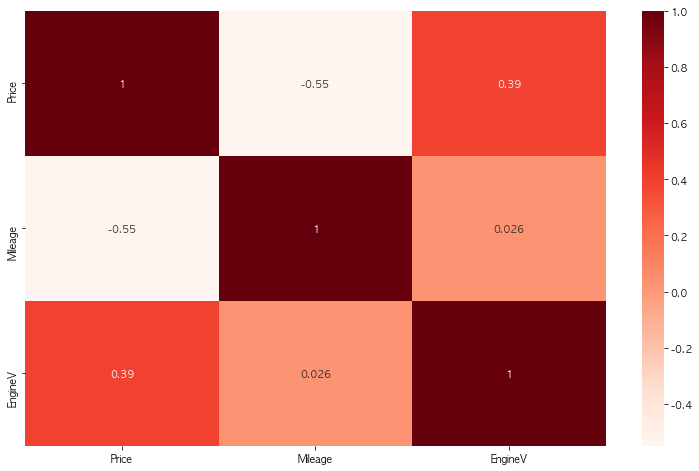

In [218]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(drop_set_df[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### simpleimputer 방식

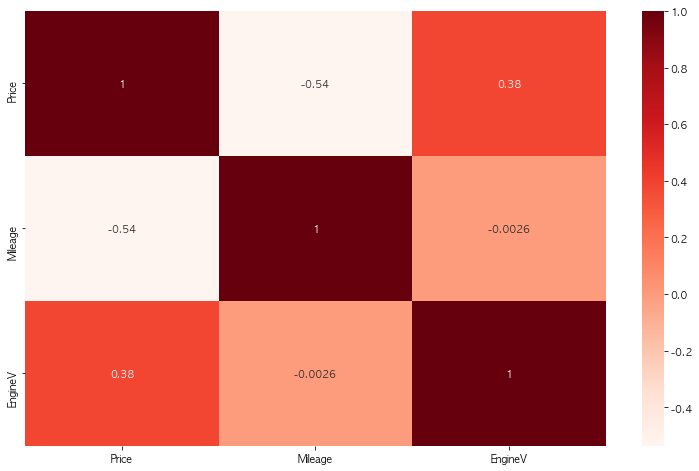

In [219]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(simple_set_df[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### IterativeImputer 방식

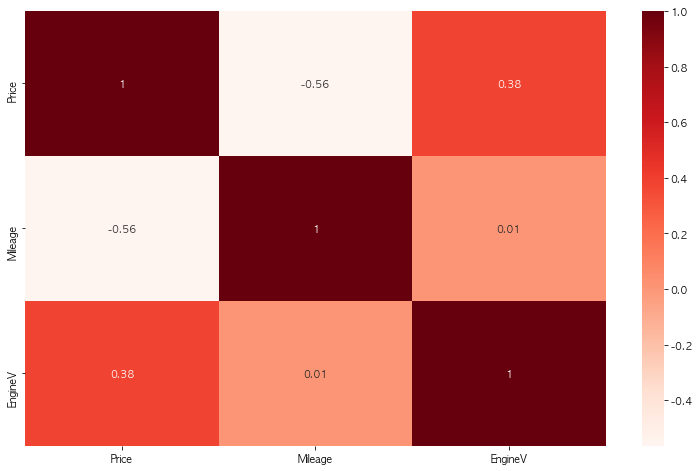

In [220]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(itera_set_df[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

## 3-2. 각 열마다의 그래프 확인

#### dropna 방식

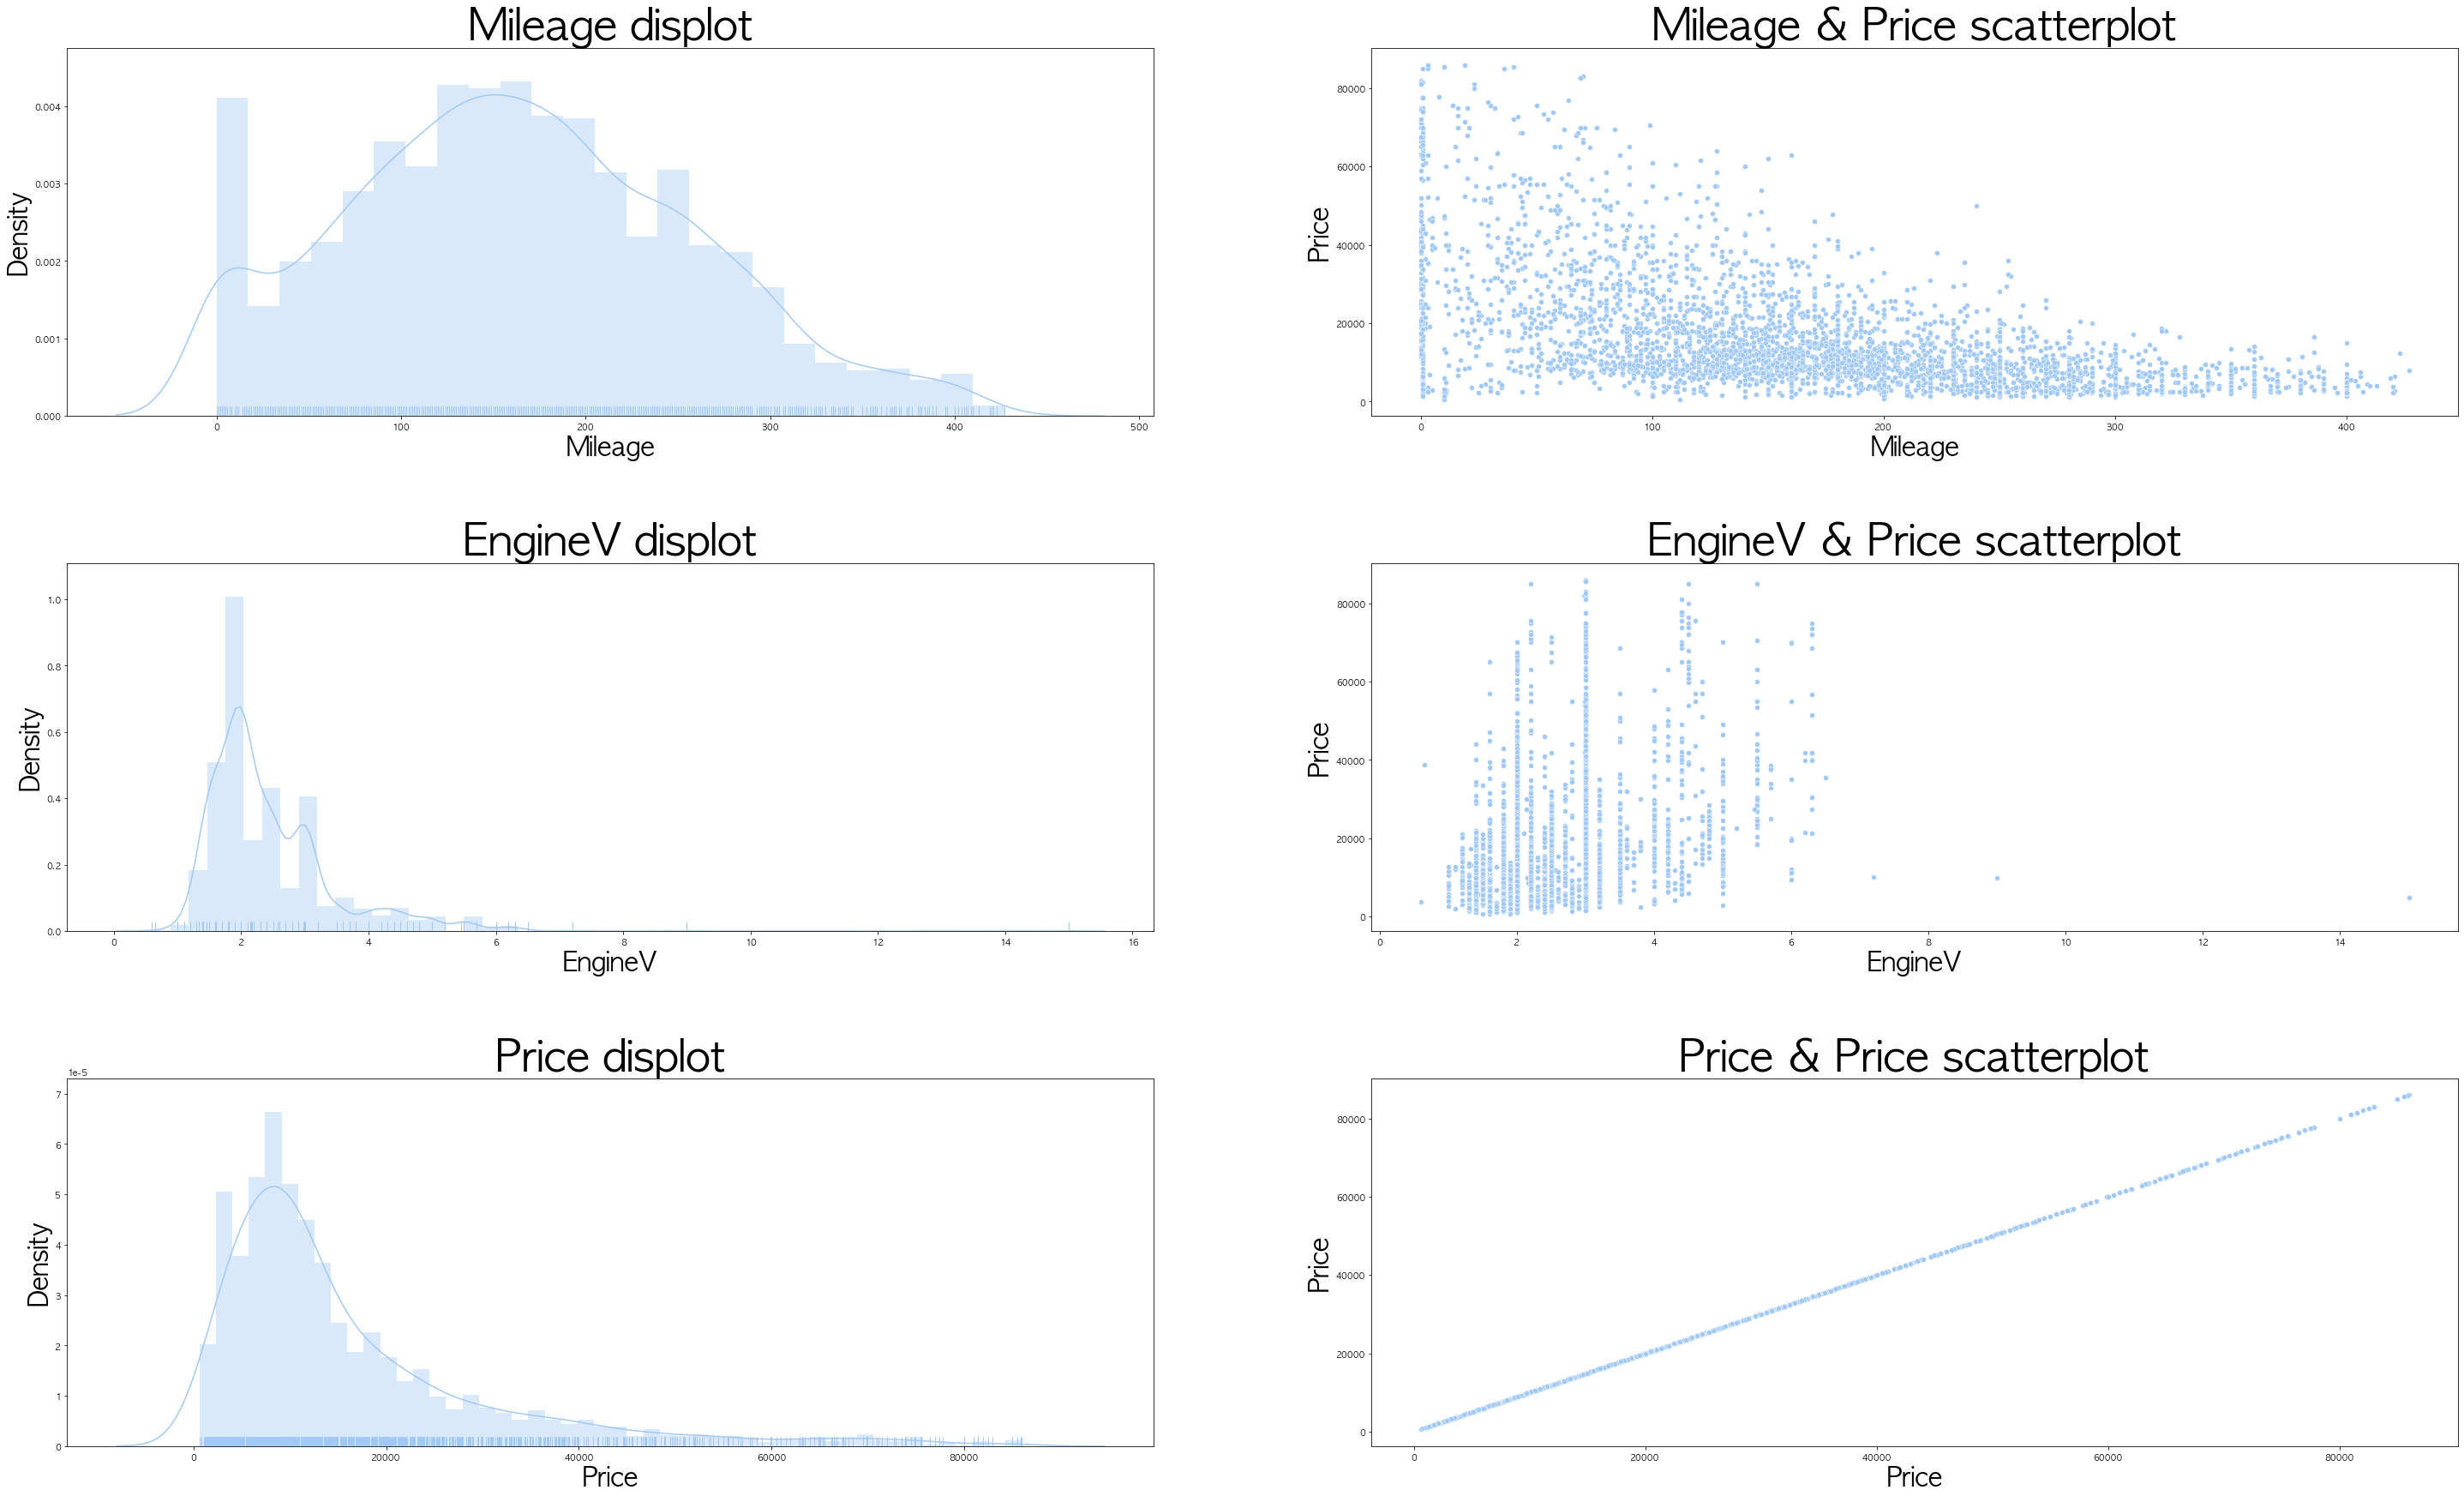

In [221]:
fig, axes = plt.subplots(3,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Price']

count = 0 
for i in range(3):
    
    globals()['b{}'.format(i)] =  sns.distplot(drop_set_df[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = drop_set_df,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

&nbsp;

#### simpleimputer 방식

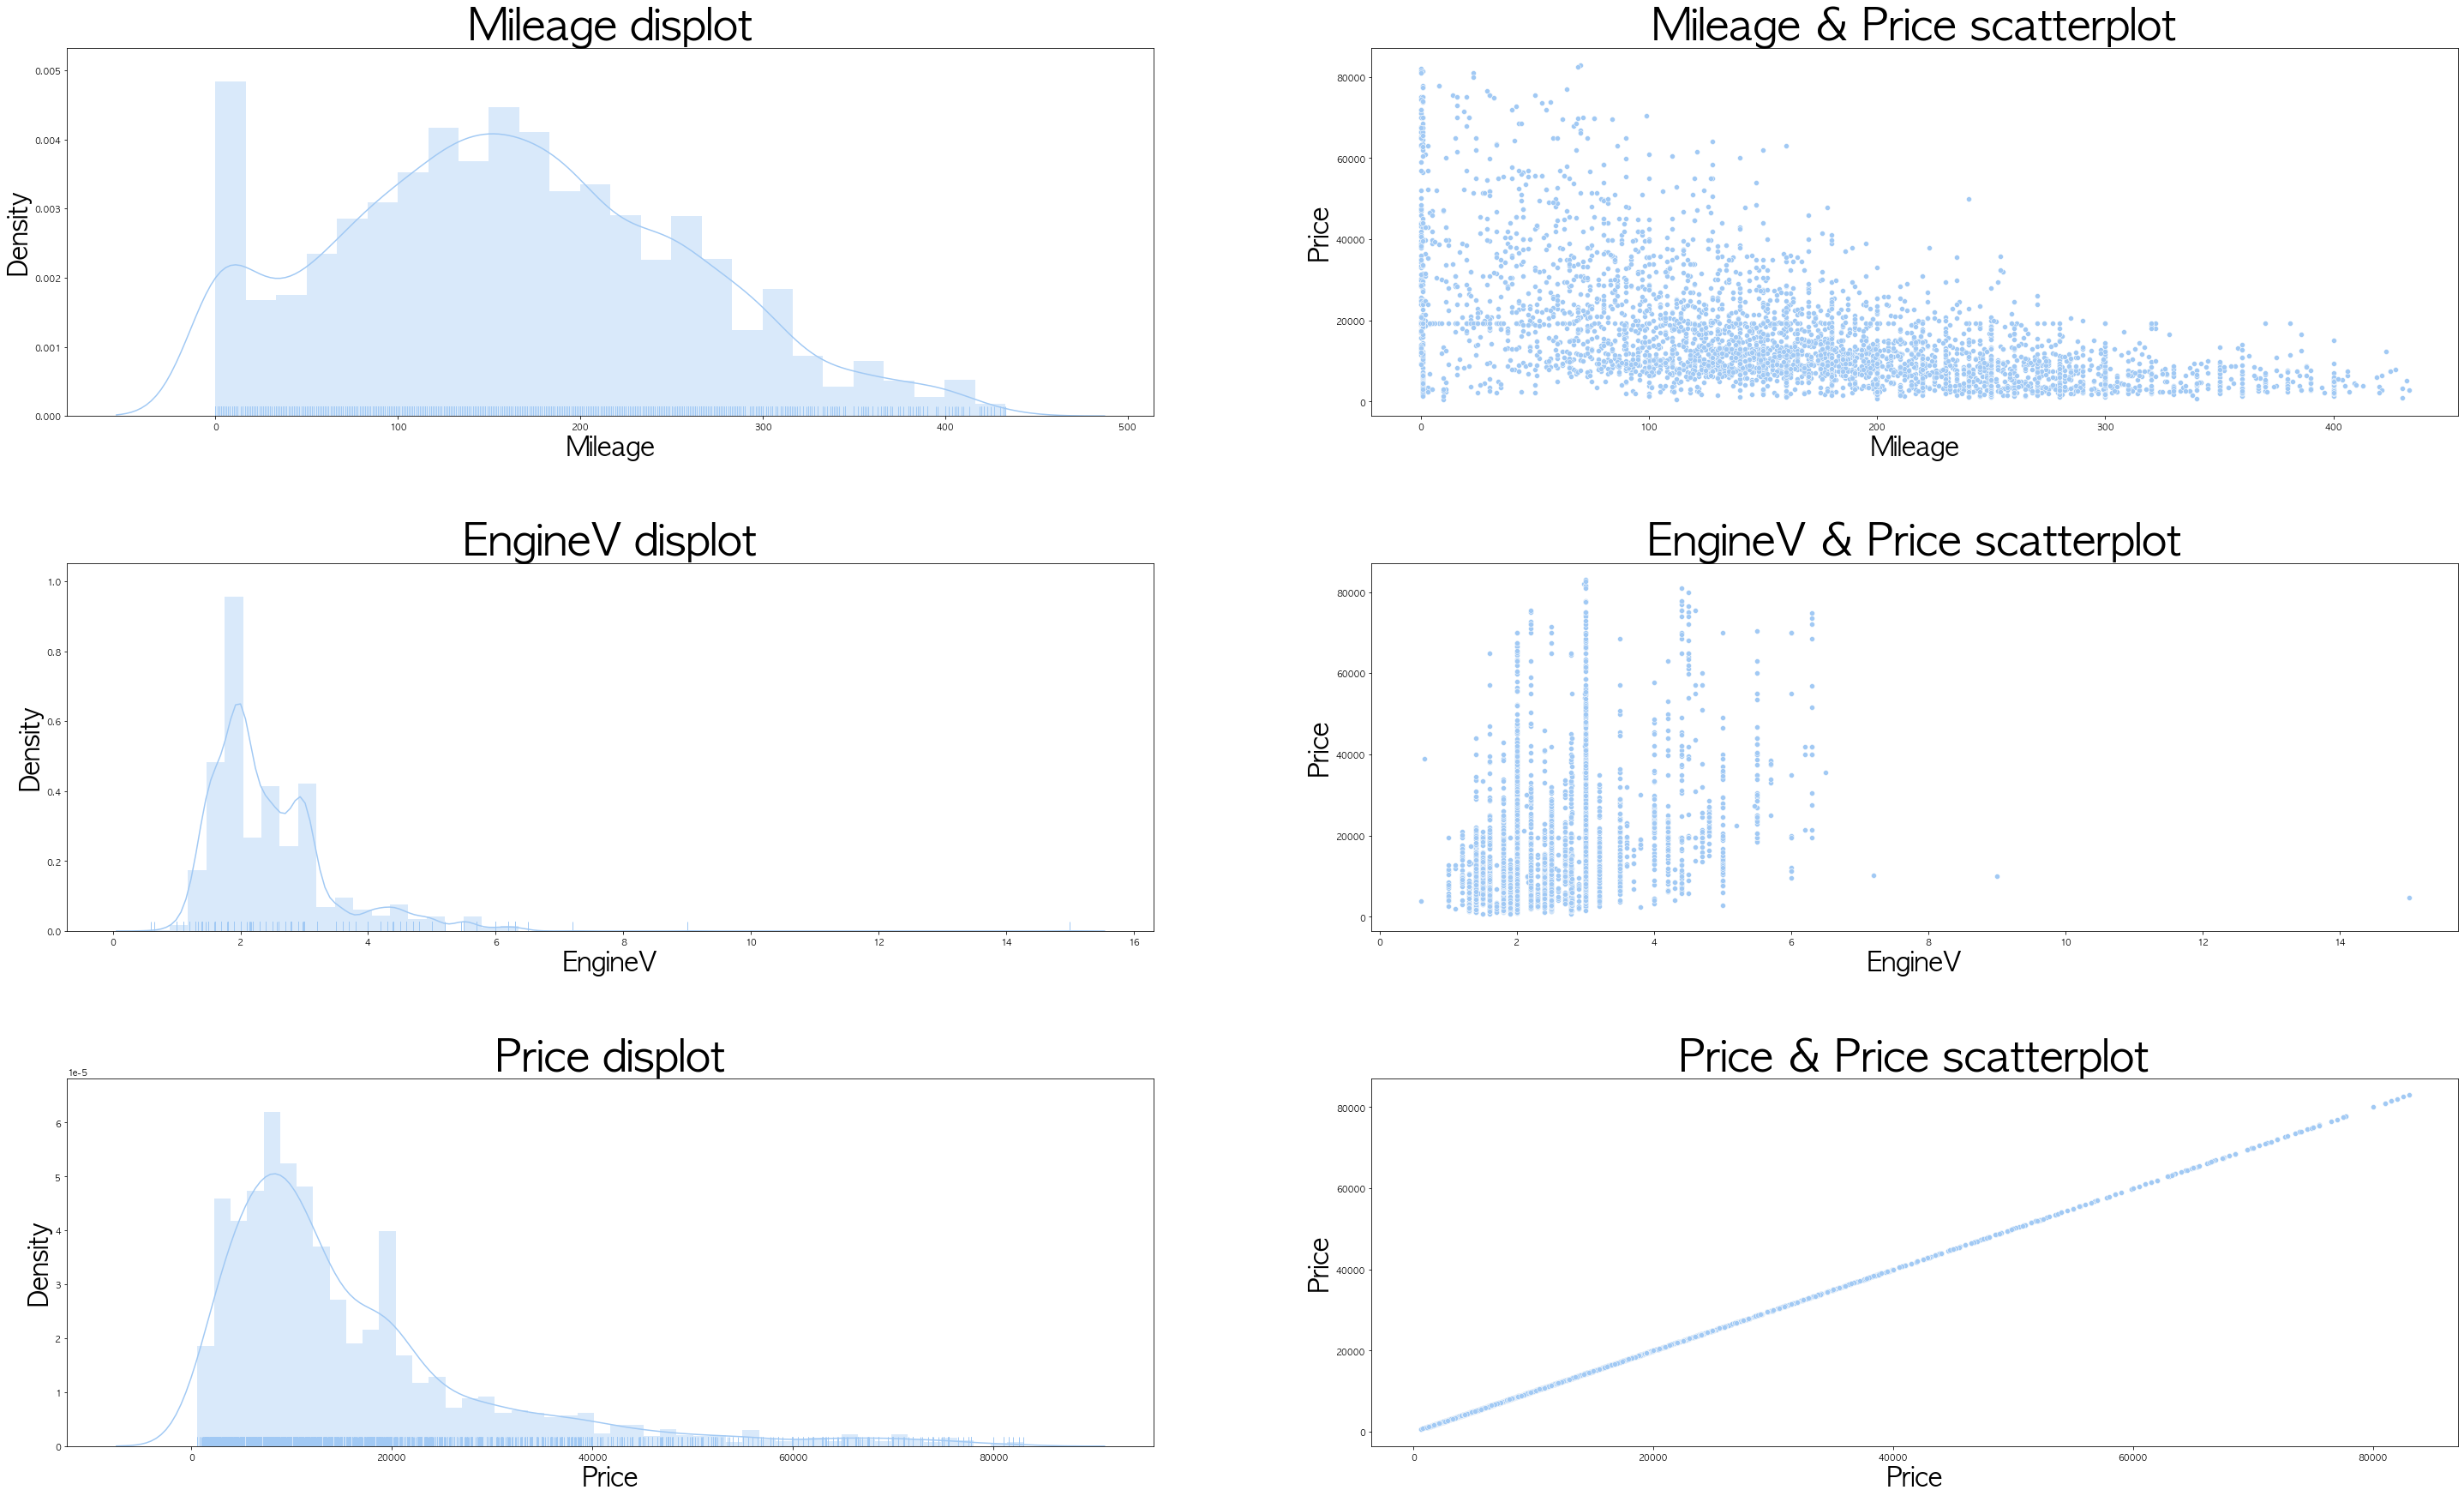

In [222]:
fig, axes = plt.subplots(3,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Price']

count = 0 
for i in range(3):
    
    globals()['b{}'.format(i)] =  sns.distplot(simple_set_df[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = simple_set_df,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

&nbsp;

#### IterativeImputer 방식

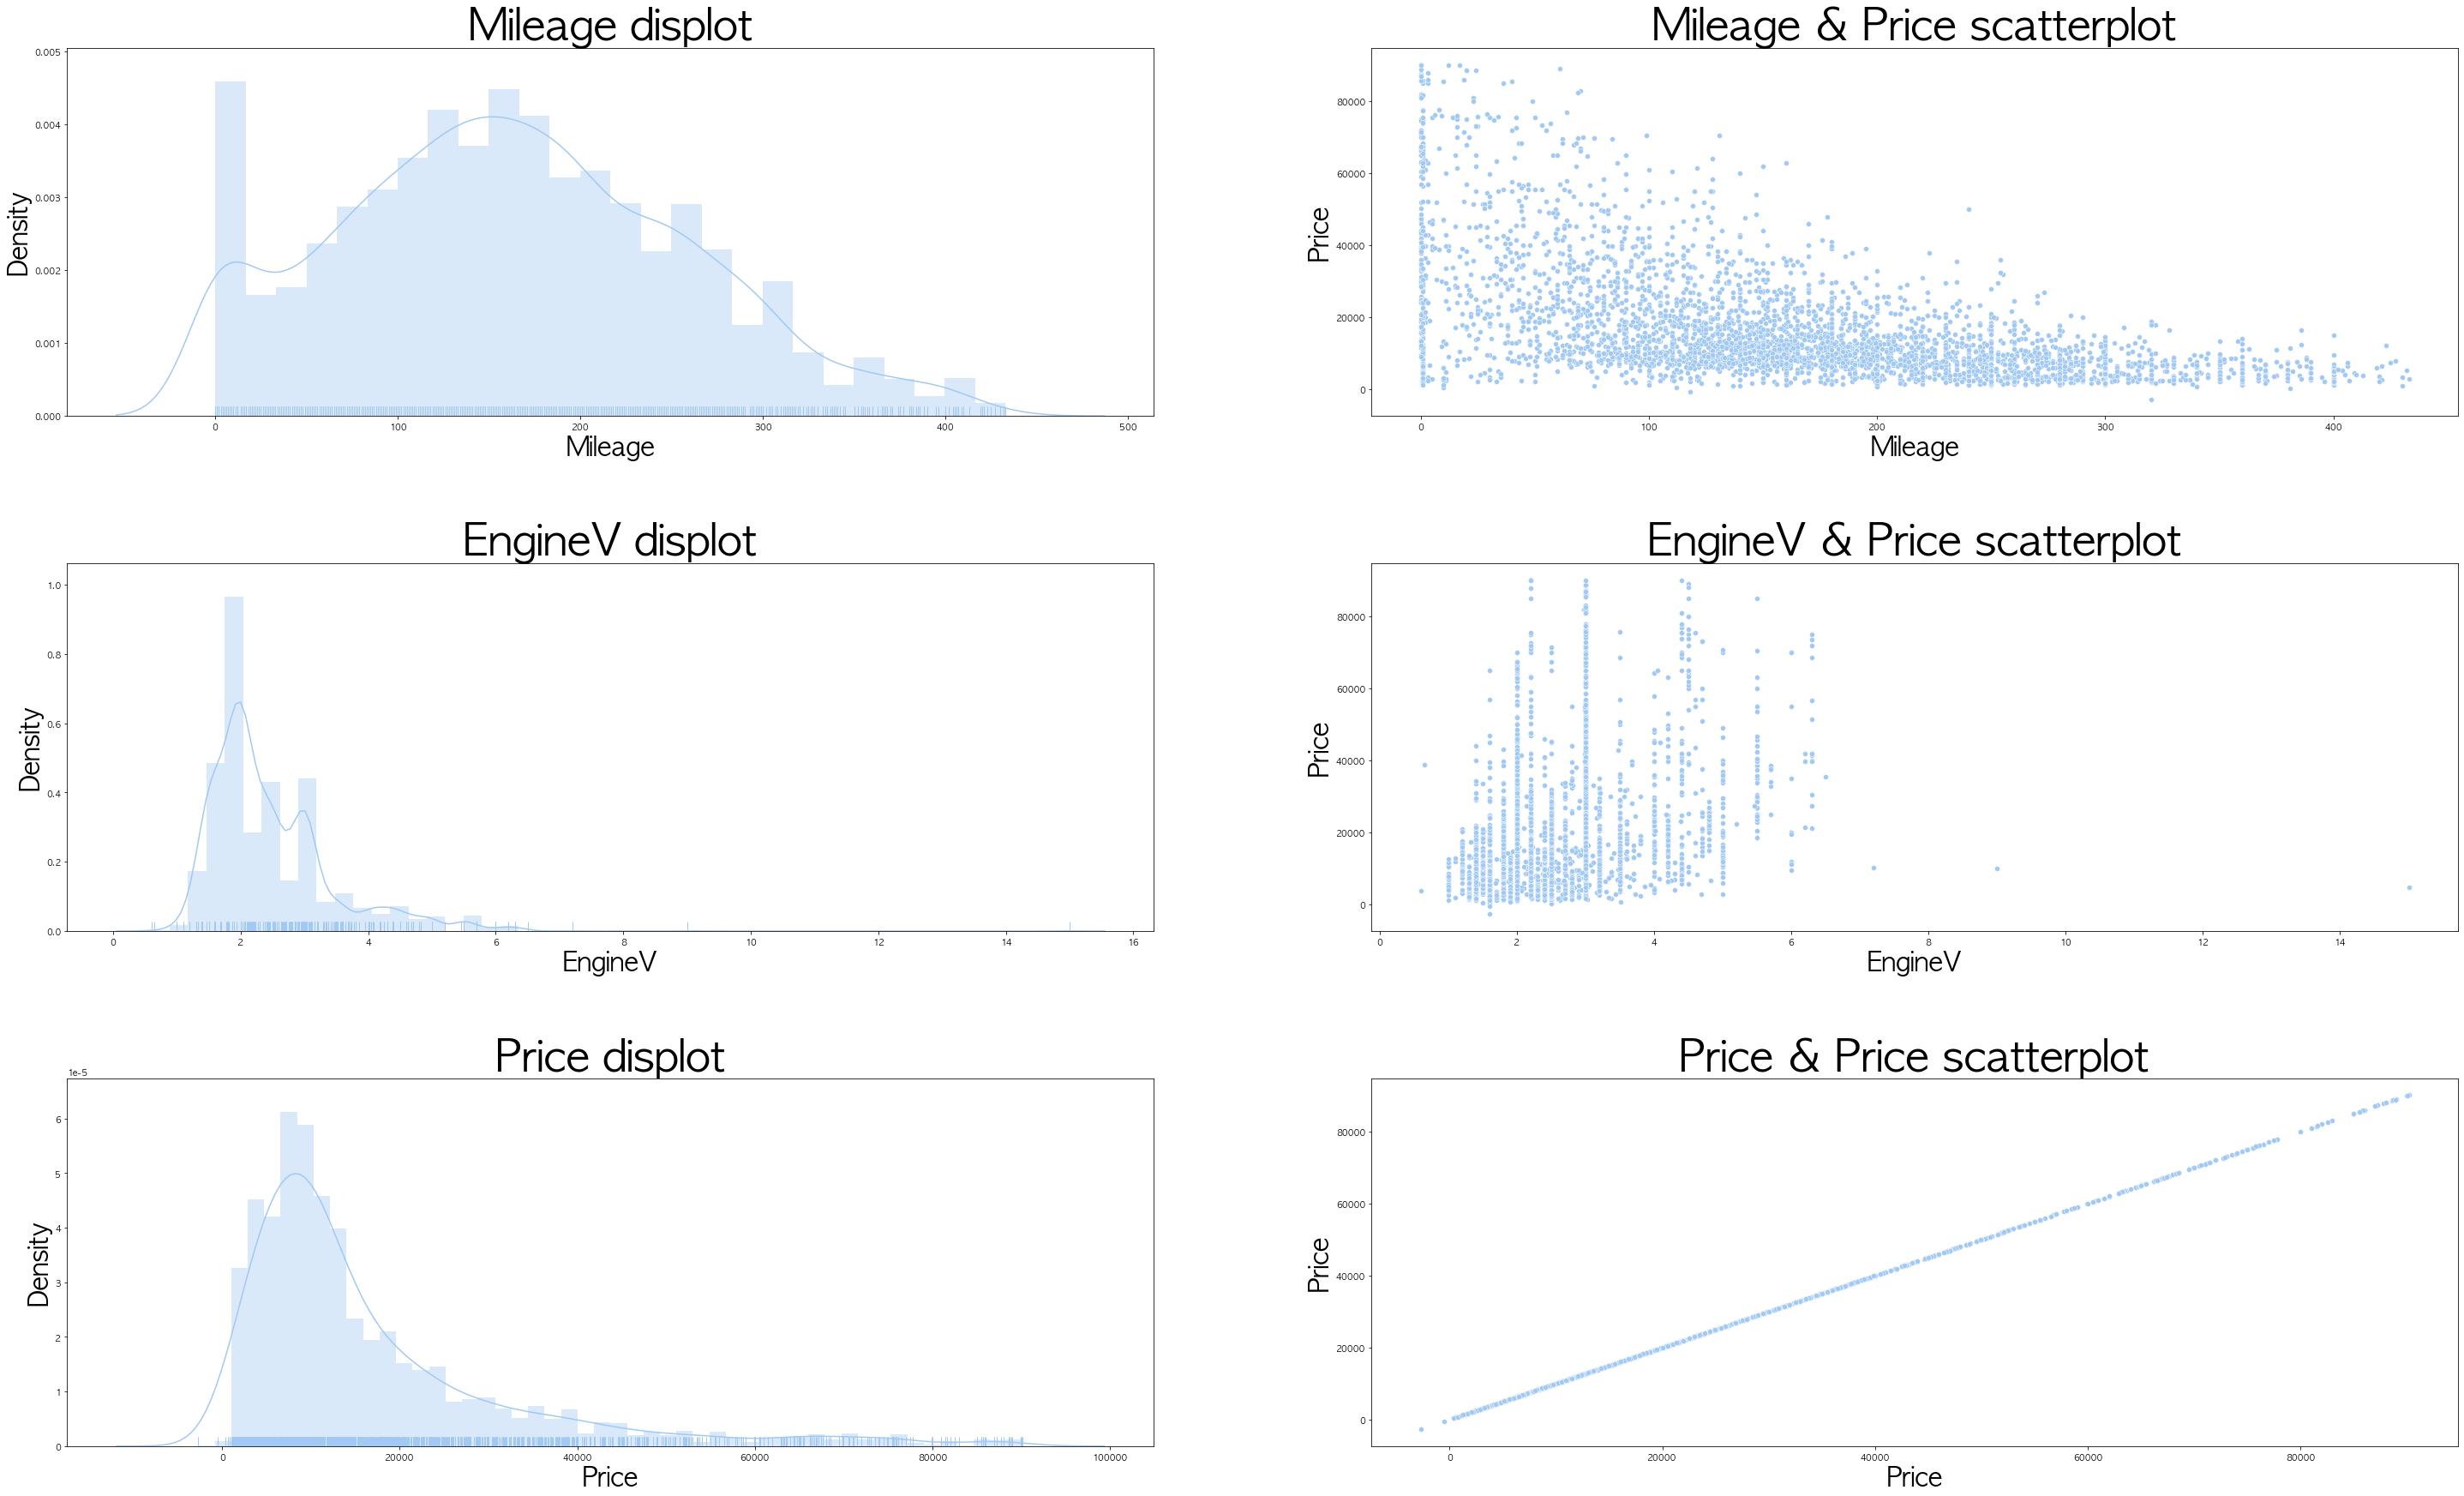

In [223]:
fig, axes = plt.subplots(3,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Price']

count = 0 
for i in range(3):
    
    globals()['b{}'.format(i)] =  sns.distplot(itera_set_df[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = itera_set_df,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

&nbsp;

## 3-3. 2번째 Outlier 잡기

#### draopna 방식

In [224]:
drop_set_df1 = drop_set_df.copy()

for i in ['Price','EngineV','Mileage']:
    clear_outlier = outlier_99(drop_set_df1,i)
    drop_set_df1 = drop_set_df1.drop(clear_outlier).reset_index().drop('index',axis=1)

Price의 outlier 갯수는: 142
EngineV의 outlier 갯수는: 117
Mileage의 outlier 갯수는: 9


&nbsp;

#### simpleimputer 방식

In [225]:
simple_set_df1 = simple_set_df.copy()
 
for i in ['Price','EngineV','Mileage']:
    clear_outlier = outlier_99(simple_set_df1,i)
    simple_set_df1 = simple_set_df1.drop(clear_outlier).reset_index().drop('index',axis=1)

Price의 outlier 갯수는: 149
EngineV의 outlier 갯수는: 118
Mileage의 outlier 갯수는: 13


&nbsp;

#### IterativeImputer 방식

In [226]:
itera_set_df1 = itera_set_df.copy()
 
for i in ['Price','EngineV','Mileage']:
    clear_outlier = outlier_99(itera_set_df1,i)
    itera_set_df1 = itera_set_df1.drop(clear_outlier).reset_index().drop('index',axis=1)

Price의 outlier 갯수는: 168
EngineV의 outlier 갯수는: 121
Mileage의 outlier 갯수는: 14


&nbsp;

## 3-4. 2번째 outlier 제거후 그래프 확인

#### dropna 방식 

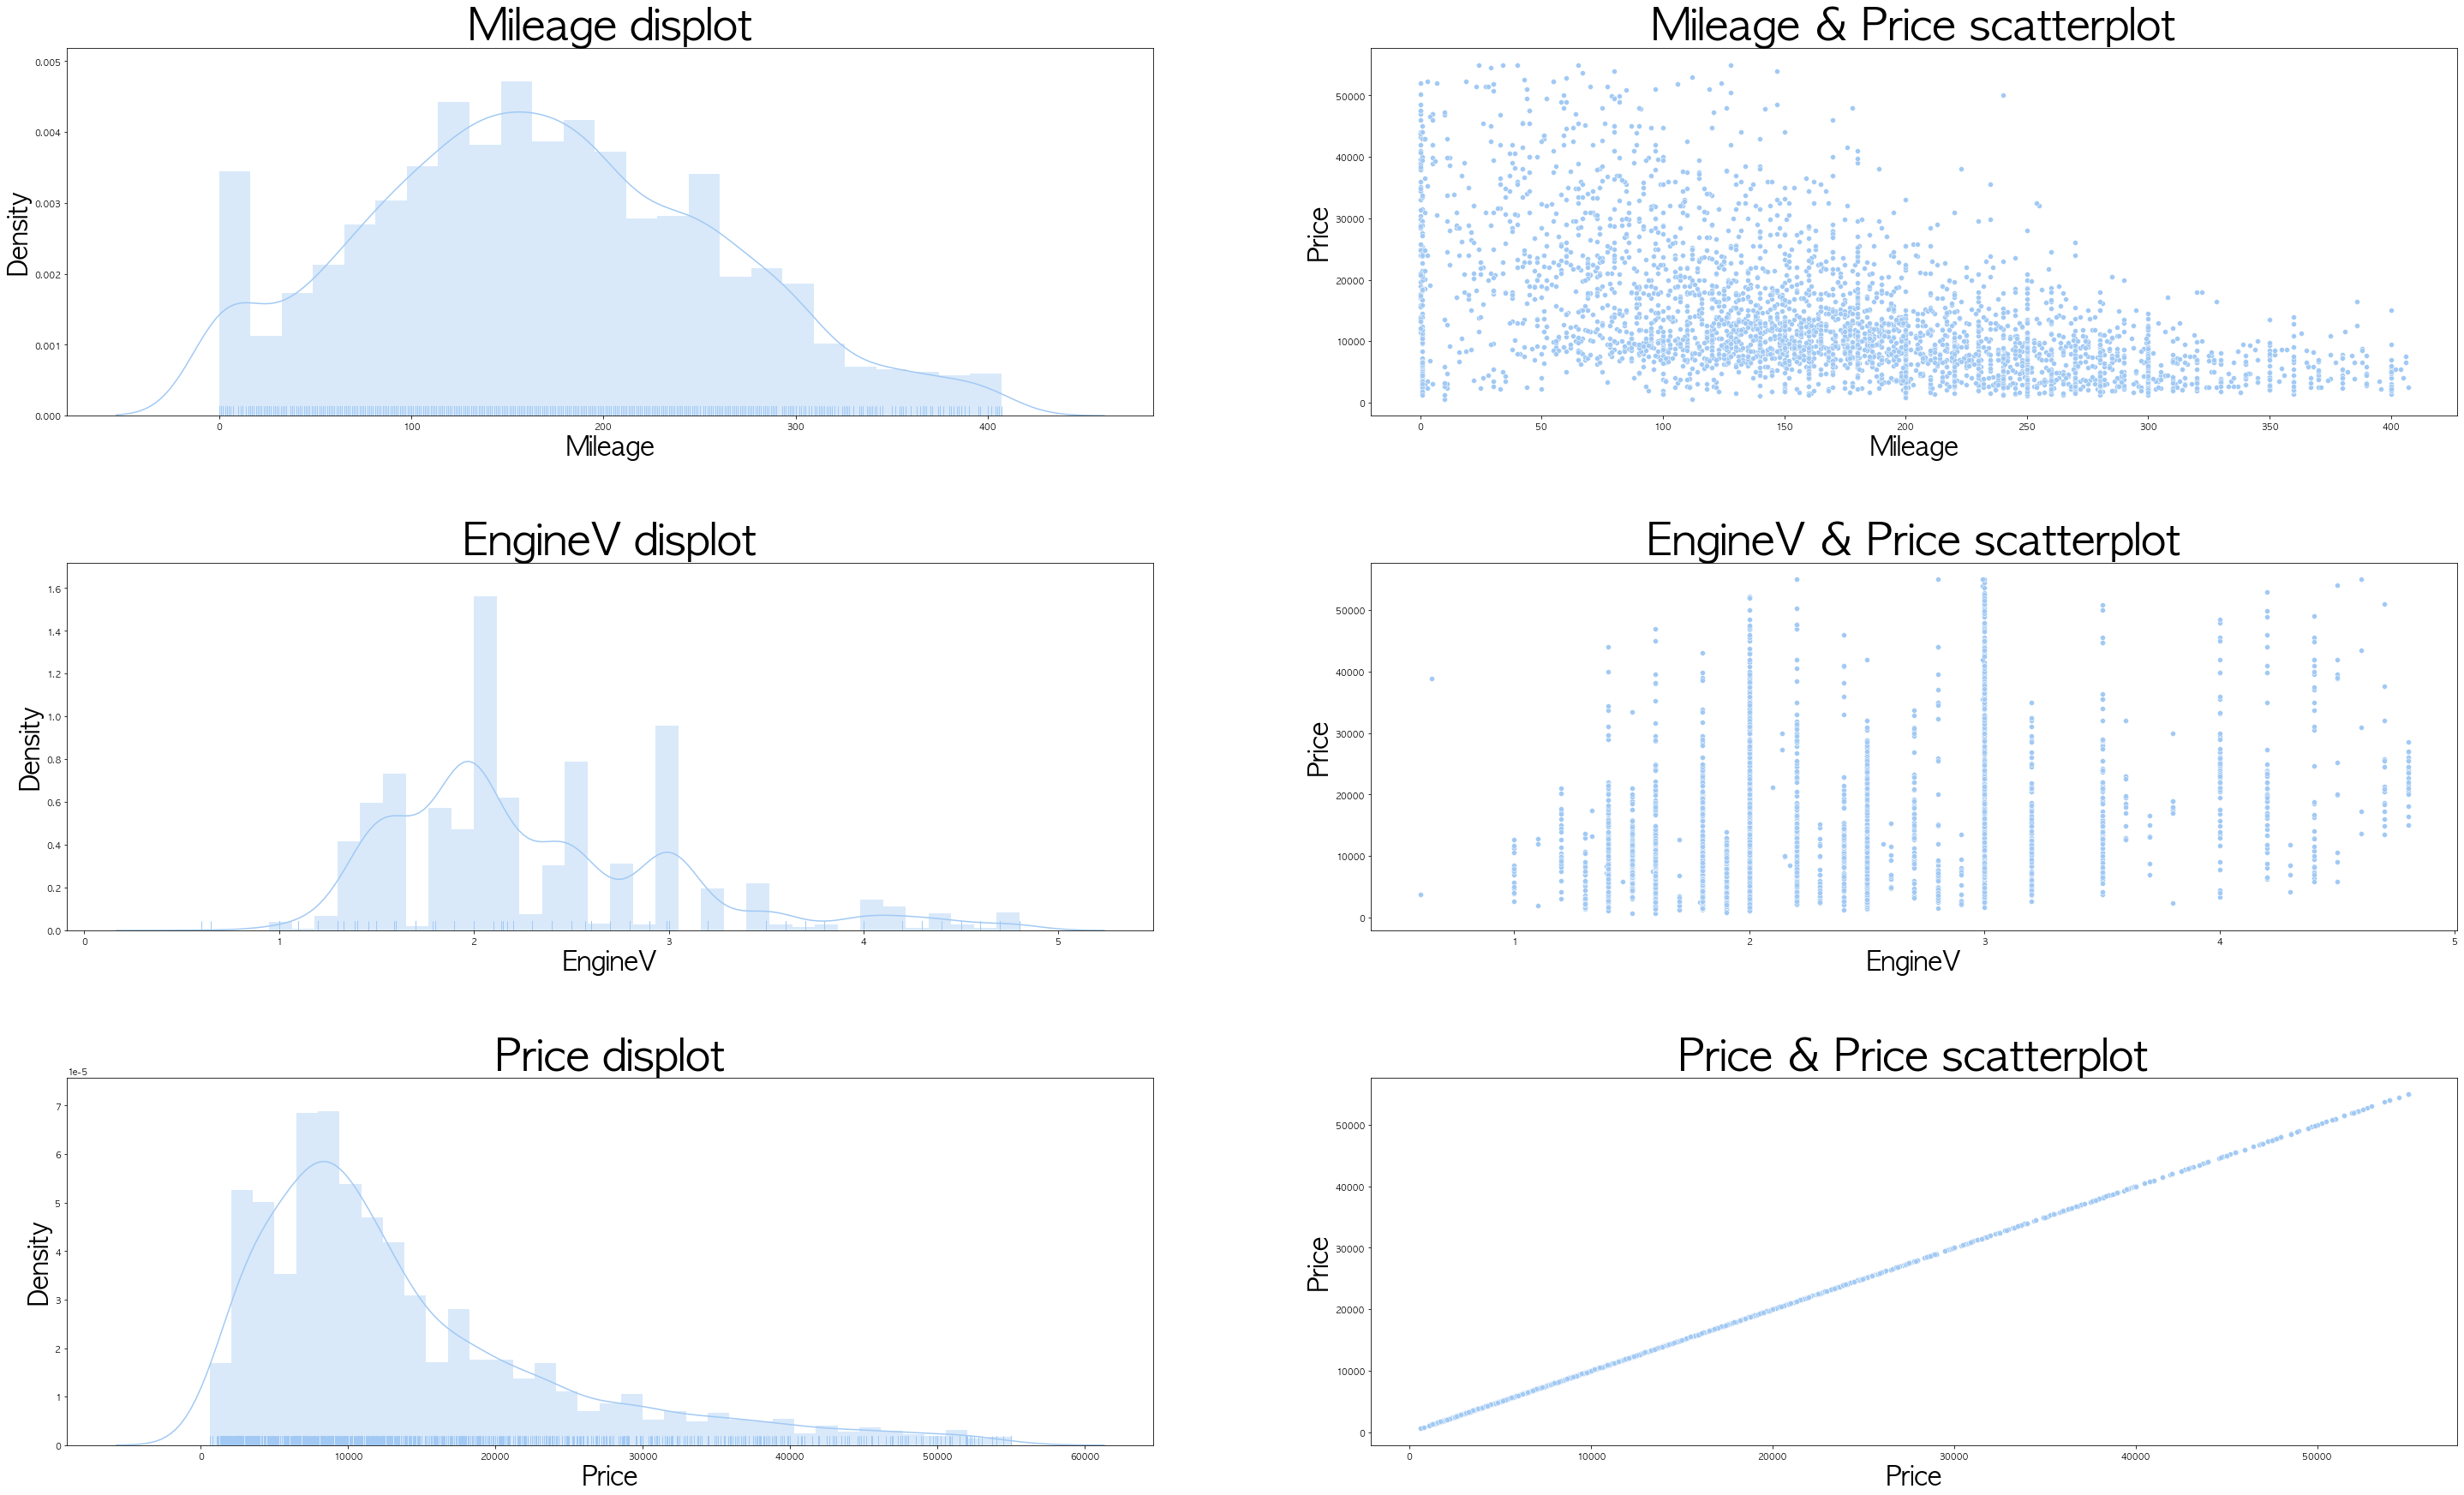

In [227]:
fig, axes = plt.subplots(3,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Price']

count = 0 
for i in range(3):
    
    globals()['b{}'.format(i)] =  sns.distplot(drop_set_df1[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = drop_set_df1,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

&nbsp;

#### simpleimputer 방식

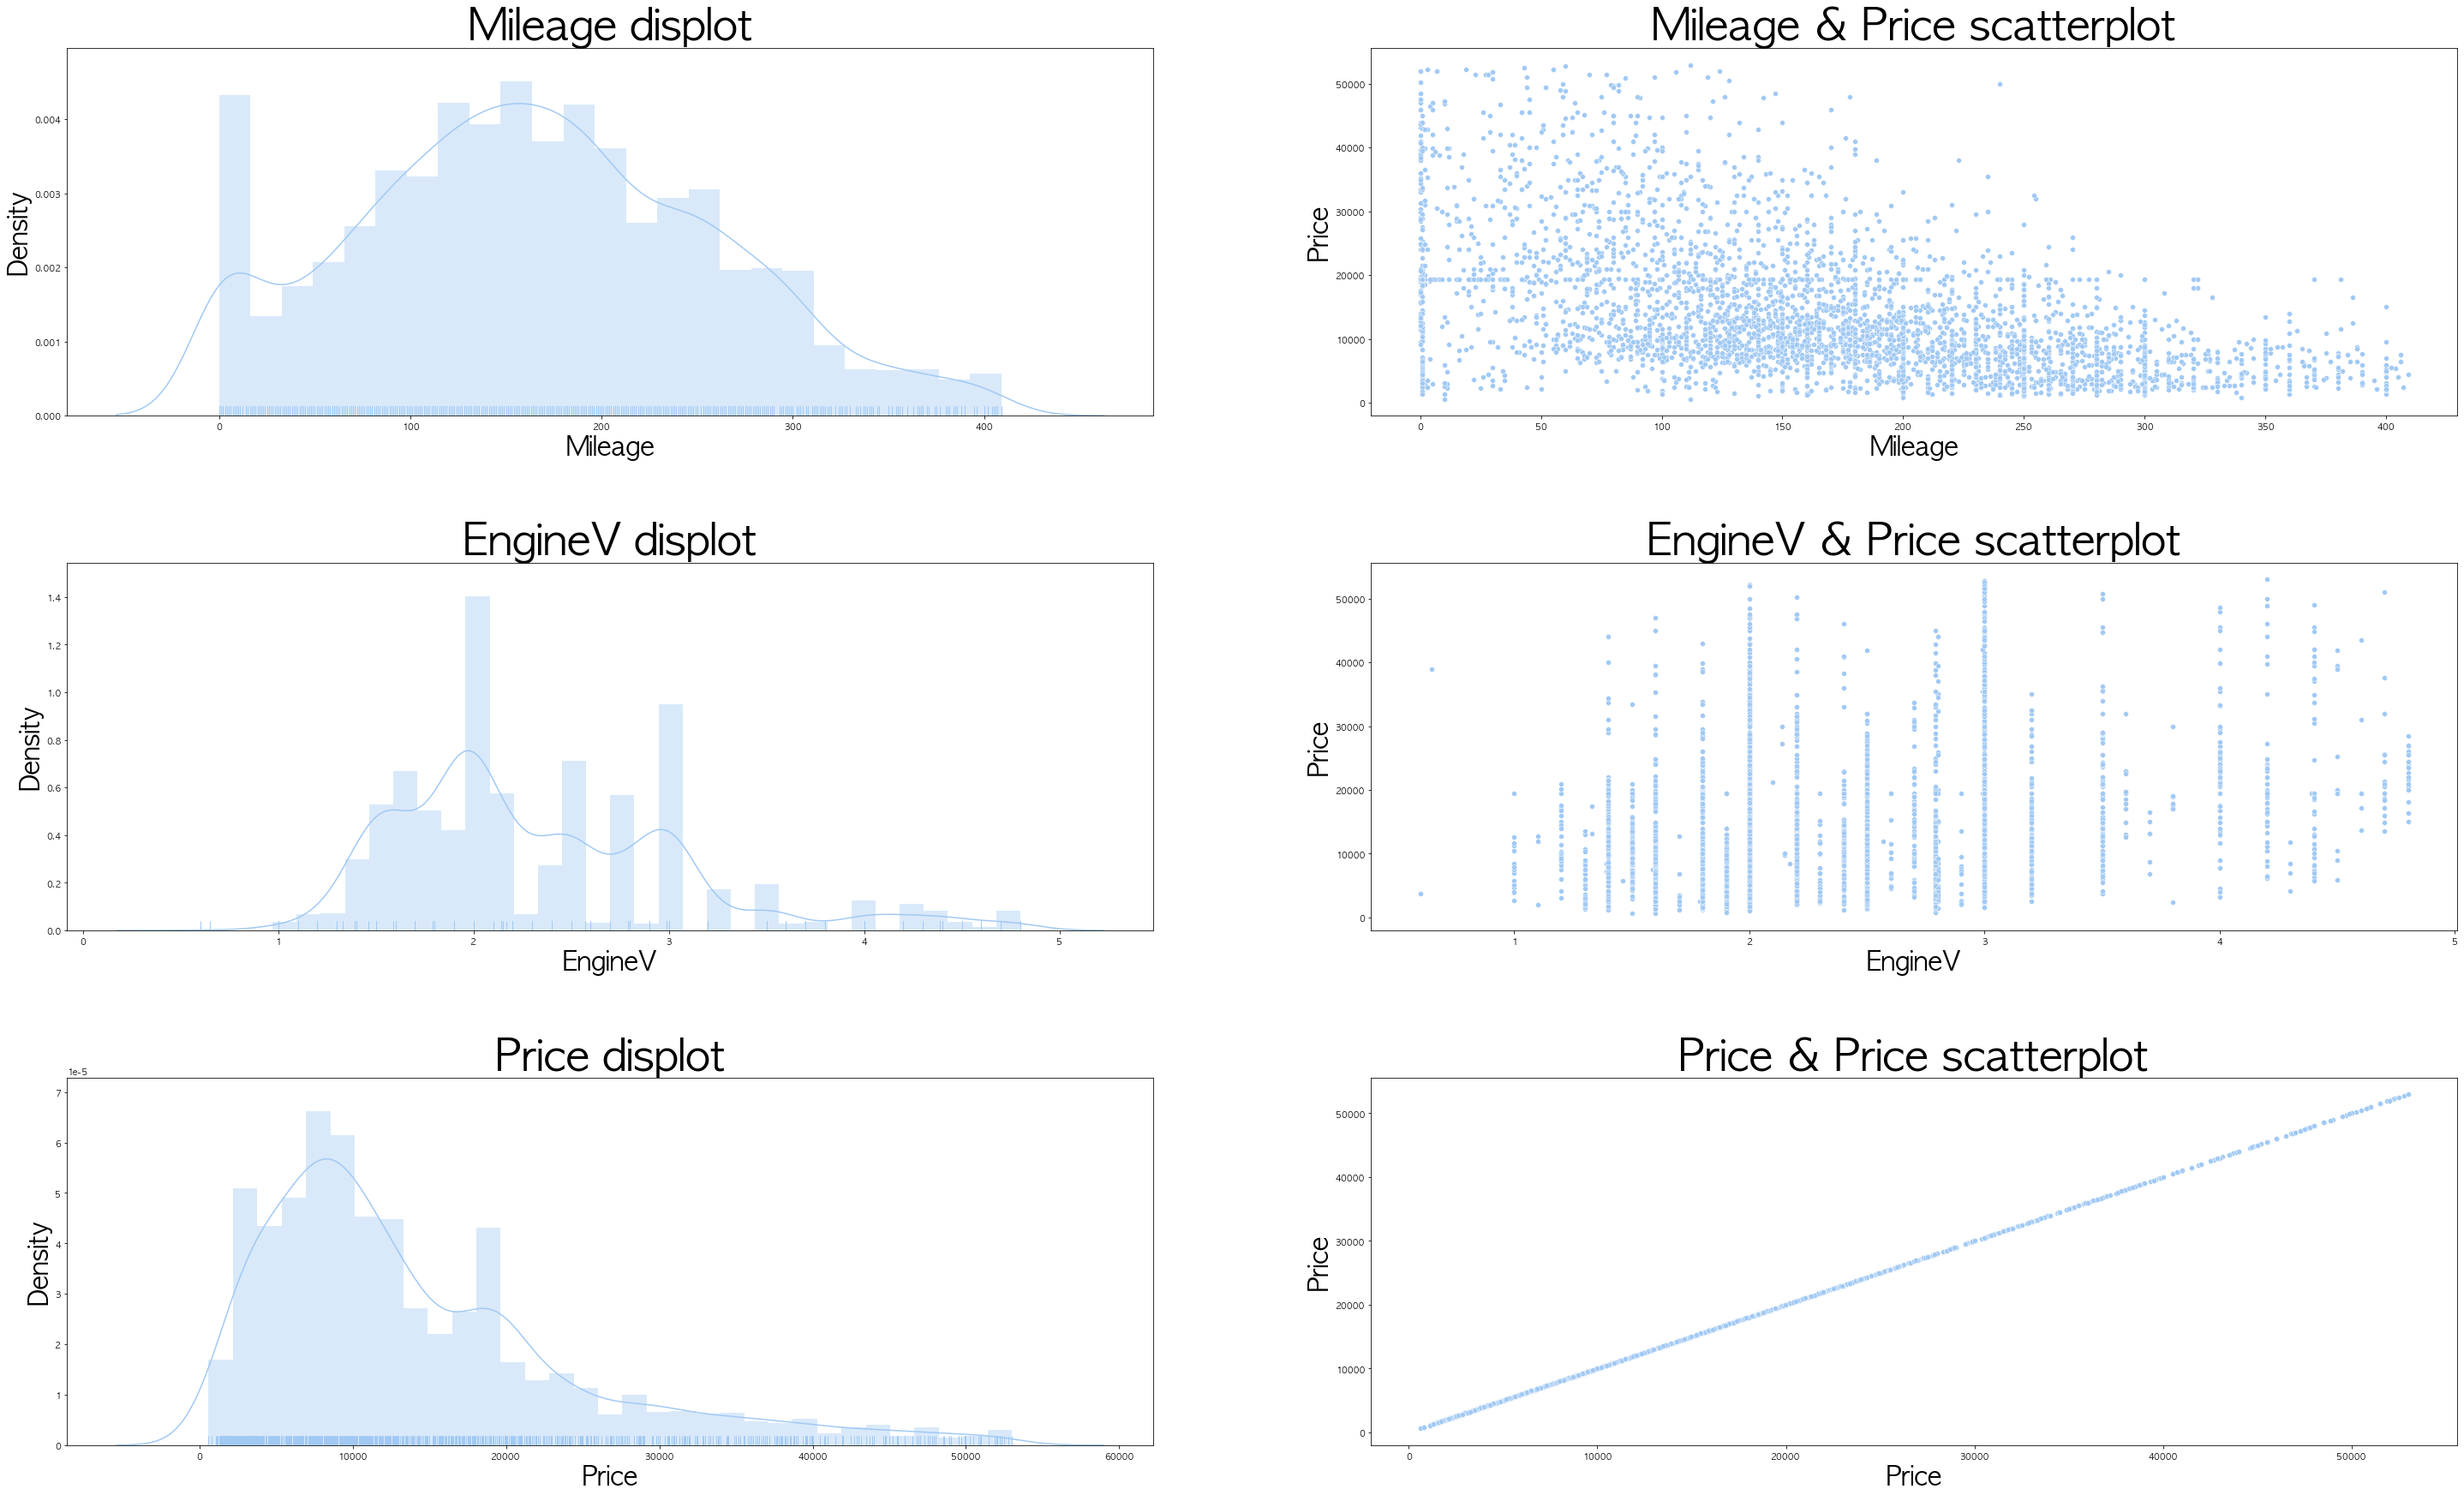

In [228]:
fig, axes = plt.subplots(3,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Price']

count = 0 
for i in range(3):
    
    globals()['b{}'.format(i)] =  sns.distplot(simple_set_df1[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = simple_set_df1,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

&nbsp;

#### IterativeImputer 방식

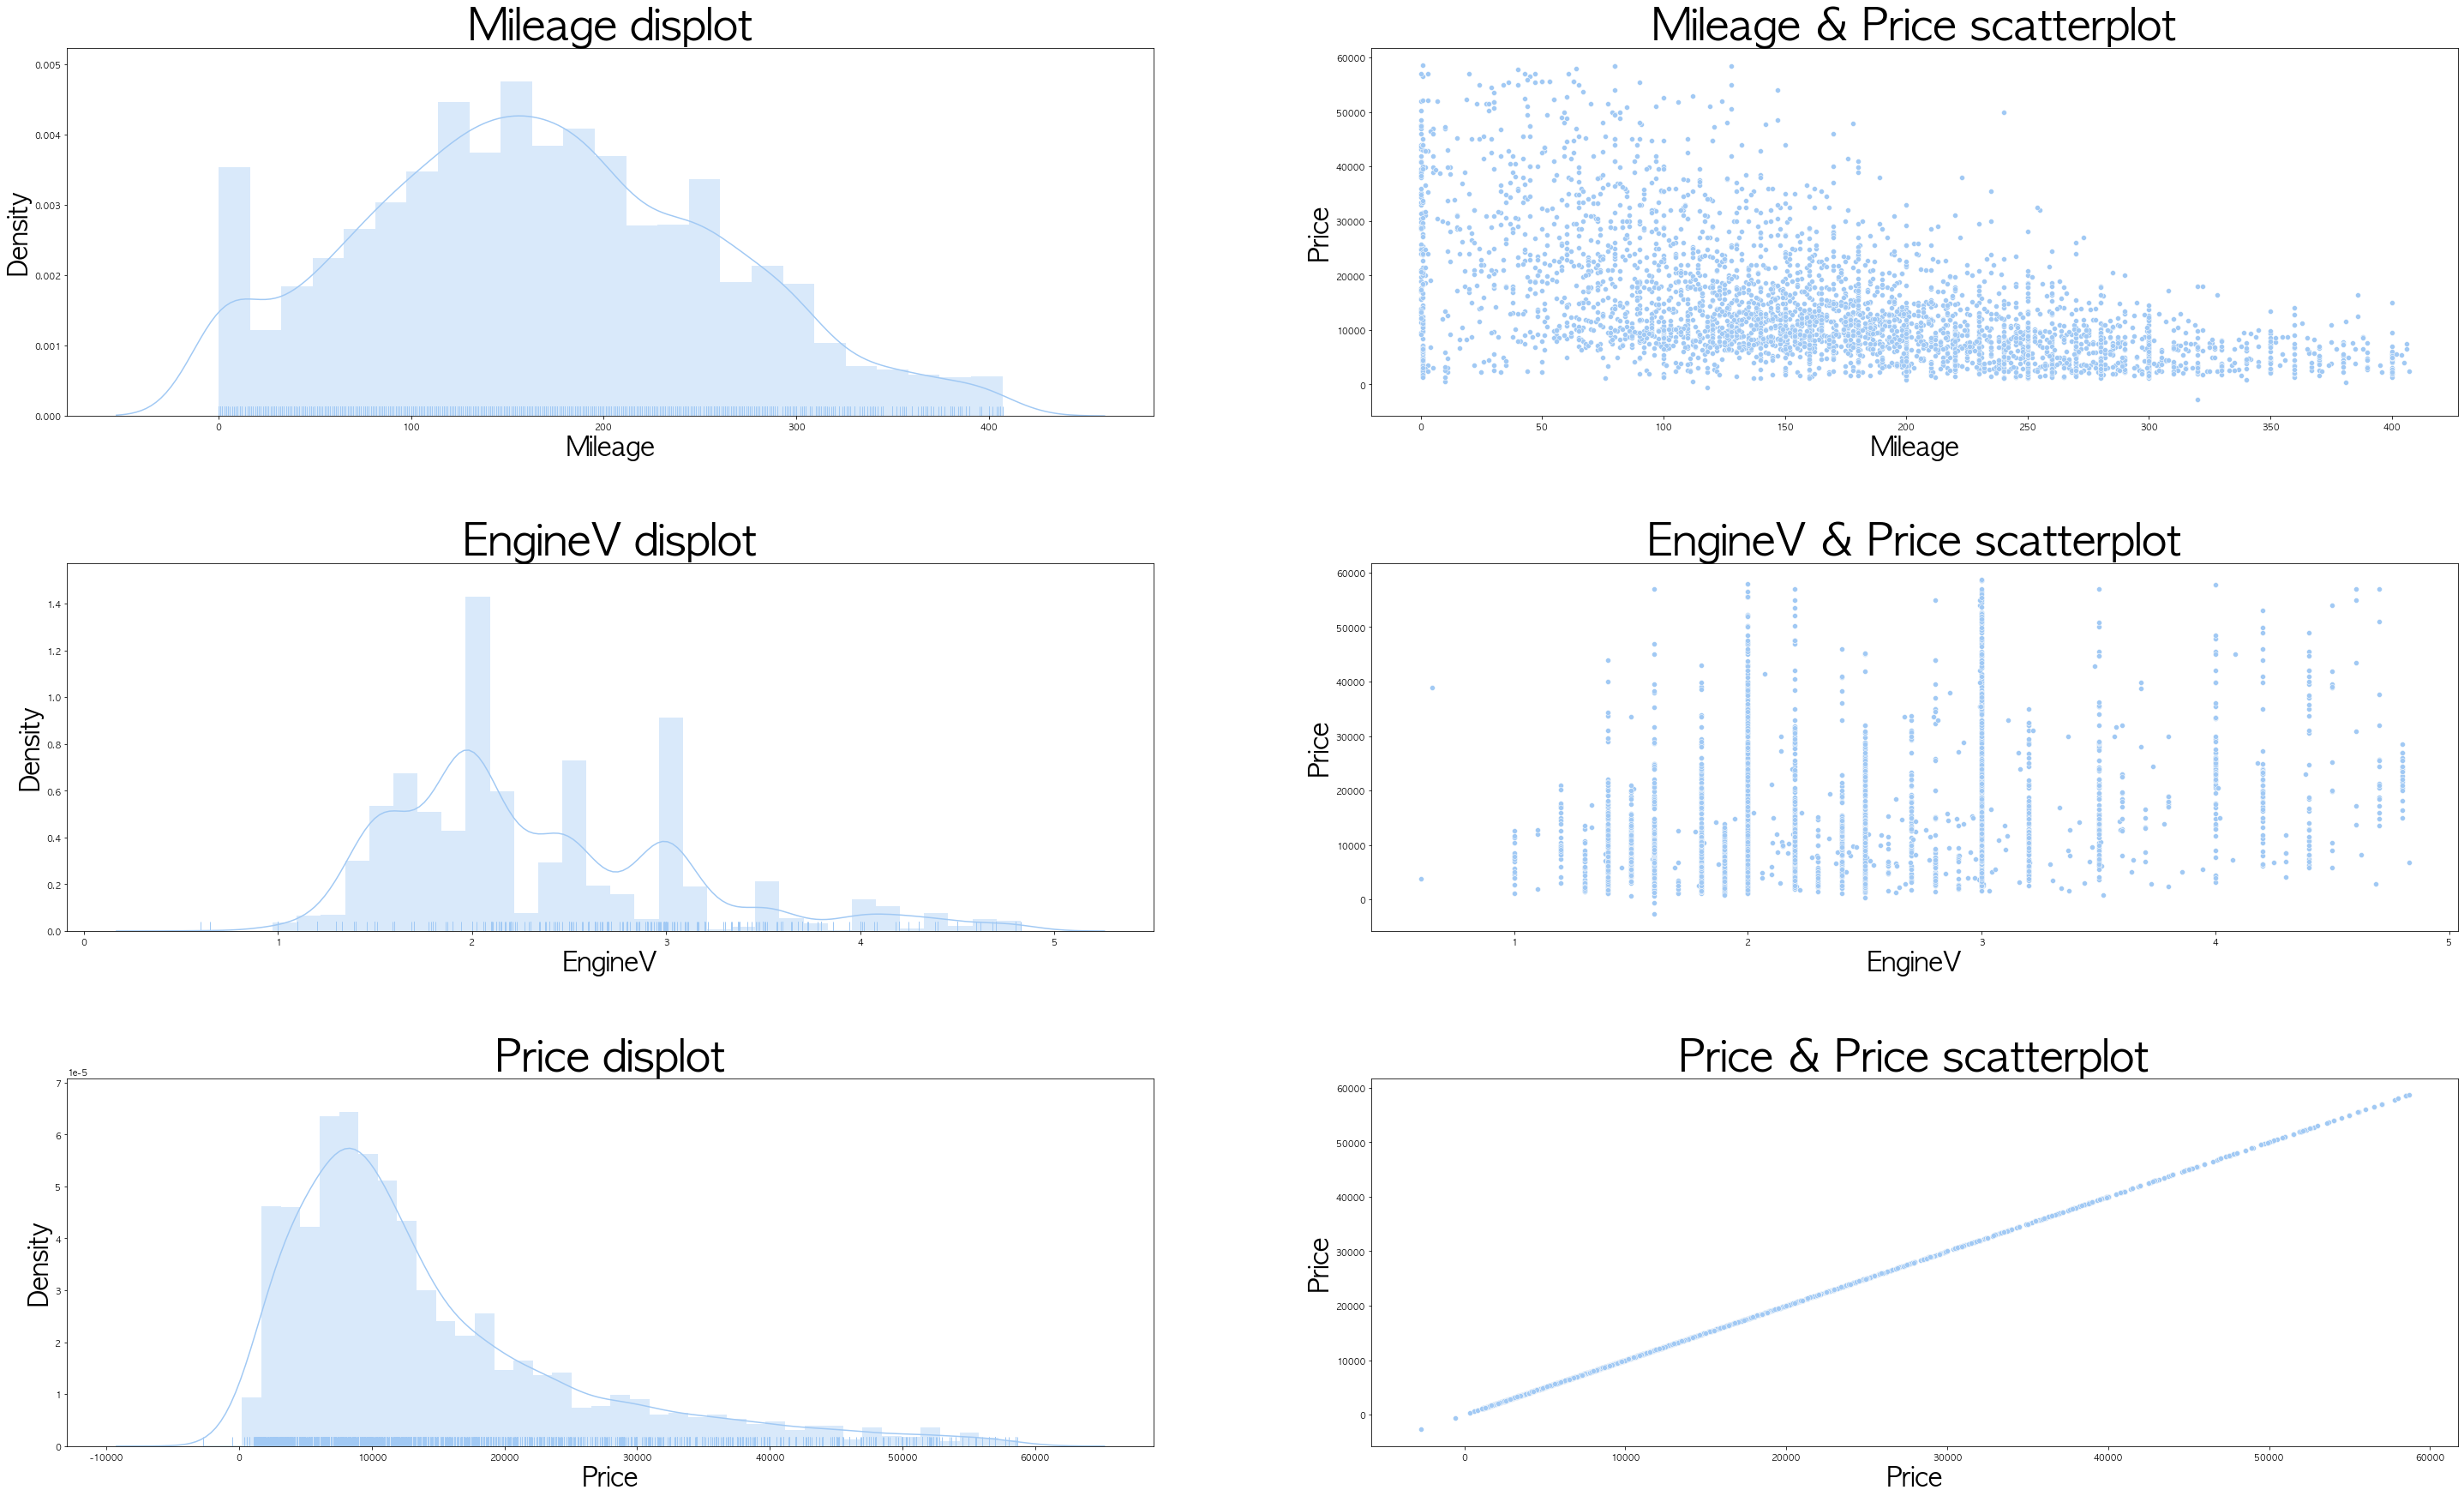

In [229]:
fig, axes = plt.subplots(3,2,figsize=(50, 30))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)


name_list = ['Mileage','EngineV','Price']

count = 0 
for i in range(3):
    
    globals()['b{}'.format(i)] =  sns.distplot(itera_set_df1[name_list[i]],kde=True, rug=True,ax=axes[count,0])
    globals()['b{}'.format(i)].set_title(name_list[i] + ' ' + 'displot',fontsize=50)
    globals()['b{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['b{}'.format(i)].set_ylabel('Density',fontsize=30)
    
    globals()['c{}'.format(i)] =  sns.scatterplot(x=name_list[i],y='Price' ,data = itera_set_df1,ax=axes[count,1])
    globals()['c{}'.format(i)].set_title(name_list[i] + ' ' + '& Price scatterplot',fontsize=50)
    globals()['c{}'.format(i)].set_xlabel(name_list[i],fontsize=30)
    globals()['c{}'.format(i)].set_ylabel('Price',fontsize=30)
    
    count+=1

plt.show()

&nbsp;

## 3-5. 2번째 outlier제거후에 상관관계 분석

#### dropna 방식

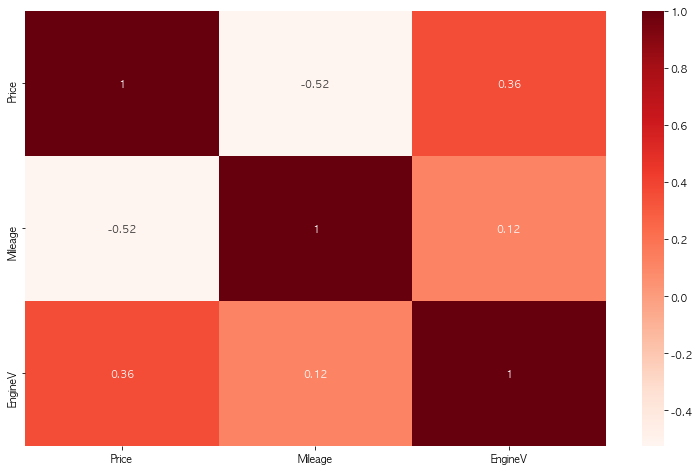

In [230]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(drop_set_df1[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### simpleimputer 방식

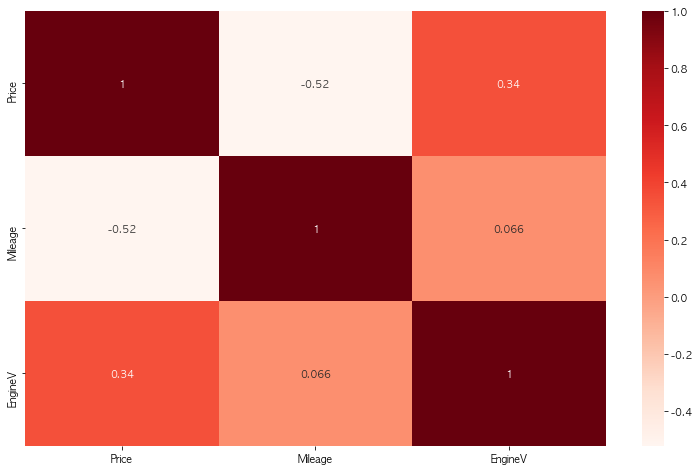

In [231]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(simple_set_df1[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### IterativeImputer 방식

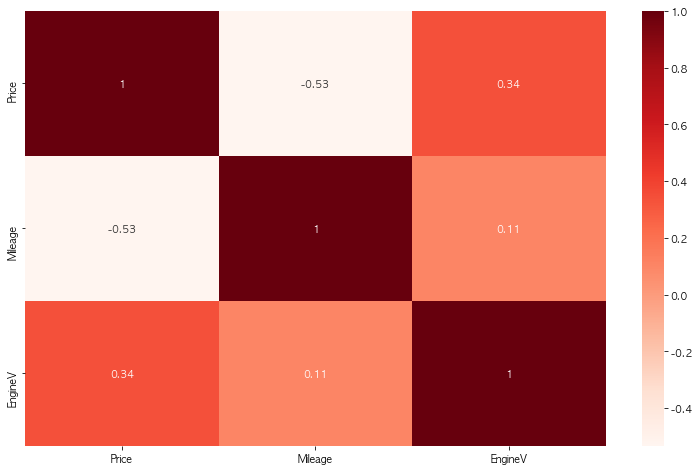

In [232]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(itera_set_df1[['Price','Mileage','EngineV']].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

## 3-6. 변환전과 변환후의 그래프 확인

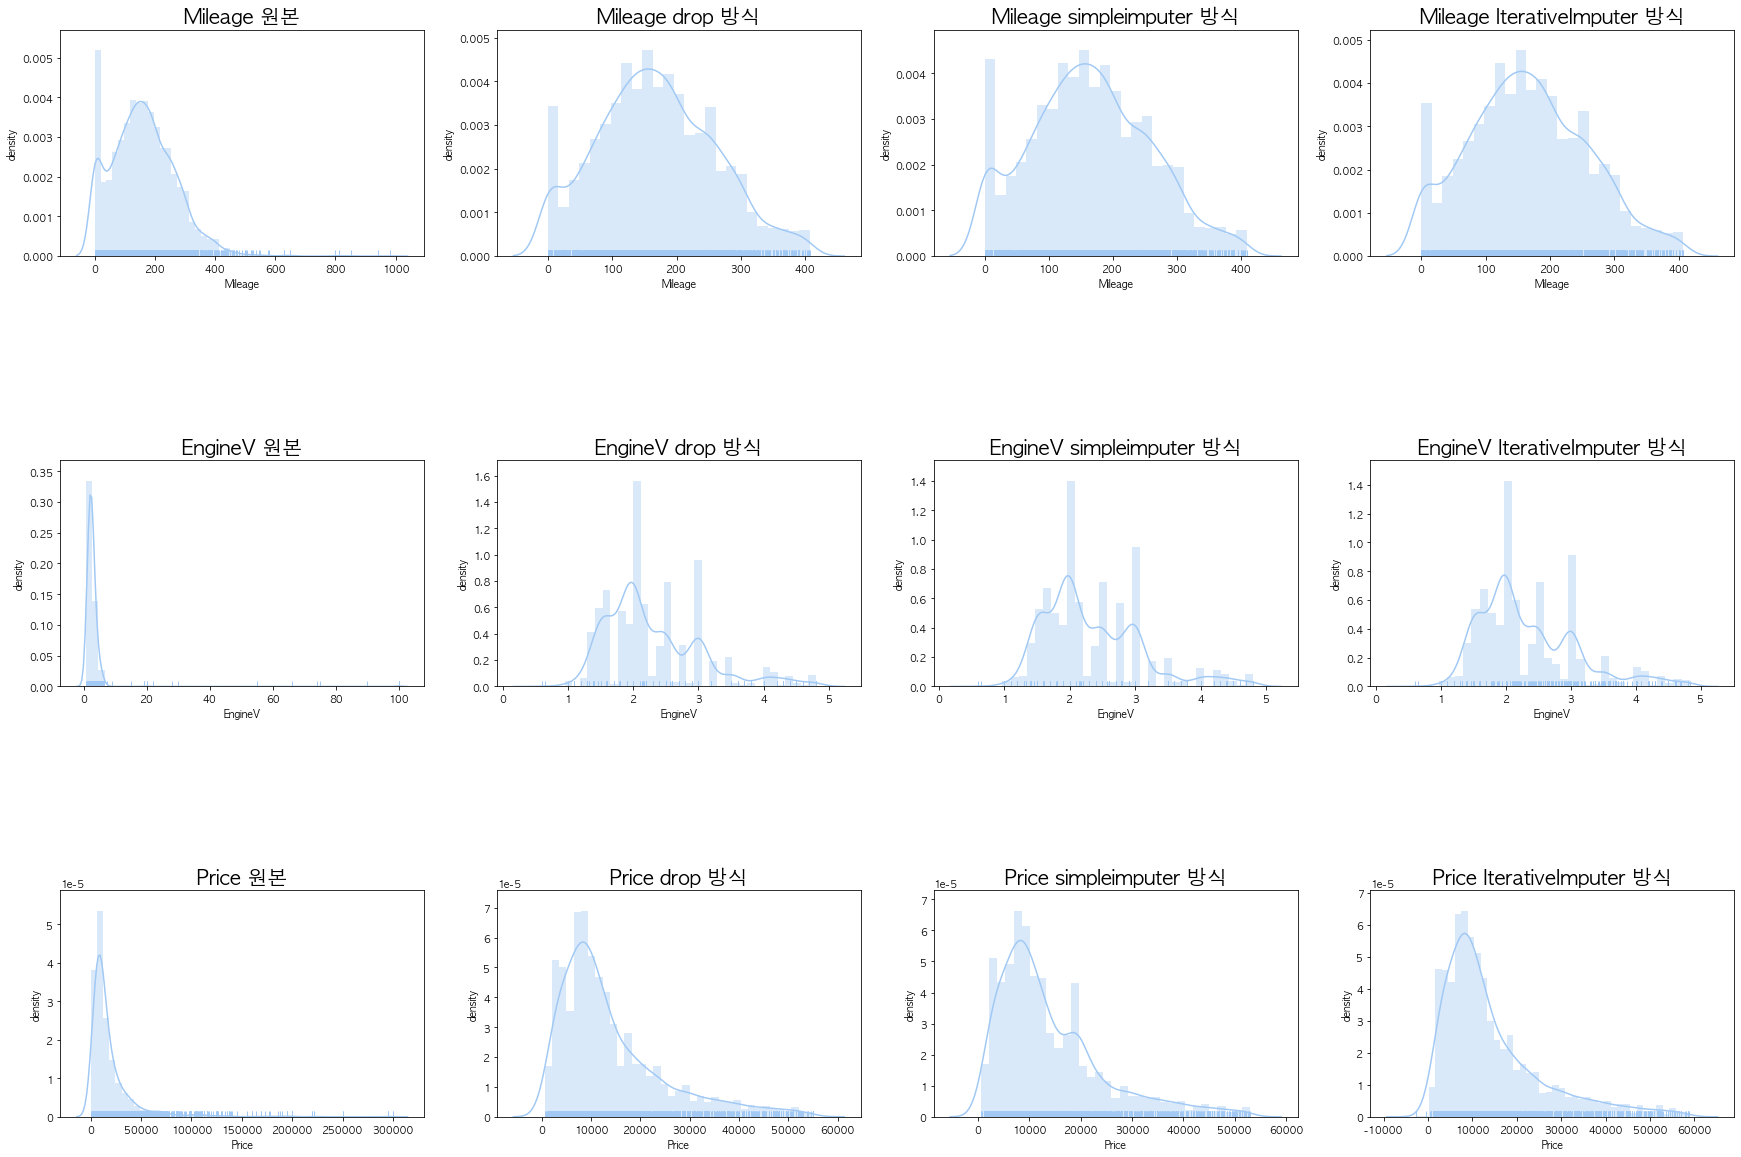

In [233]:
fig, axes = plt.subplots(3,4,figsize=(30, 20))
plt.subplots_adjust(wspace=0.2, hspace = 0.9)

name_list = ['Mileage','EngineV','Price']


for d,i in enumerate(name_list): 

    
    globals()['before_{}'.format(d)] = sns.distplot(vihicle_data[i],kde=True, rug=True,ax=axes[d,0])
    globals()['before_{}'.format(d)].set_title(i + ' ' + '원본',fontsize=20)
    globals()['before_{}'.format(d)].set_xlabel(i,fontsize=10)
    globals()['before_{}'.format(d)].set_ylabel('density',fontsize=10)
    
    
    globals()['after_1{}'.format(d)] = sns.distplot(drop_set_df1[i],kde=True, rug=True,ax=axes[d,1])
    globals()['after_1{}'.format(d)].set_title(i + ' ' + 'drop 방식',fontsize=20)
    globals()['after_1{}'.format(d)].set_xlabel(i,fontsize=10)
    globals()['after_1{}'.format(d)].set_ylabel('density',fontsize=10)
    
    globals()['after_2{}'.format(d)] = sns.distplot(simple_set_df1[i],kde=True, rug=True,ax=axes[d,2])
    globals()['after_2{}'.format(d)].set_title(i + ' ' + 'simpleimputer 방식',fontsize=20)
    globals()['after_2{}'.format(d)].set_xlabel(i,fontsize=10)
    globals()['after_2{}'.format(d)].set_ylabel('density',fontsize=10)
    
    globals()['after_3{}'.format(d)] = sns.distplot(itera_set_df1[i],kde=True, rug=True,ax=axes[d,3])
    globals()['after_3{}'.format(d)].set_title(i + ' ' + 'IterativeImputer 방식',fontsize=20)
    globals()['after_3{}'.format(d)].set_xlabel(i,fontsize=10)
    globals()['after_3{}'.format(d)].set_ylabel('density',fontsize=10)

    
plt.show()

&nbsp;

## 3-7. 변환후에 상관관계 분석

#### dropna 방식

In [234]:
drop_set_df1.corr()['Price'].sort_values(axis=0 ,ascending=False).iloc[1:10]

EngineV             0.357810
Registration_yes    0.304085
Year_2016           0.241293
Year_2014           0.226114
Year_2013           0.205629
Model_Q7            0.201605
Year_2015           0.184847
Year_2011           0.174462
Model_X6            0.174038
Name: Price, dtype: float64

In [235]:
lista = [i for i in drop_set_df1.corr()['Price'].sort_values(axis=0 ,ascending=False).index][:10]

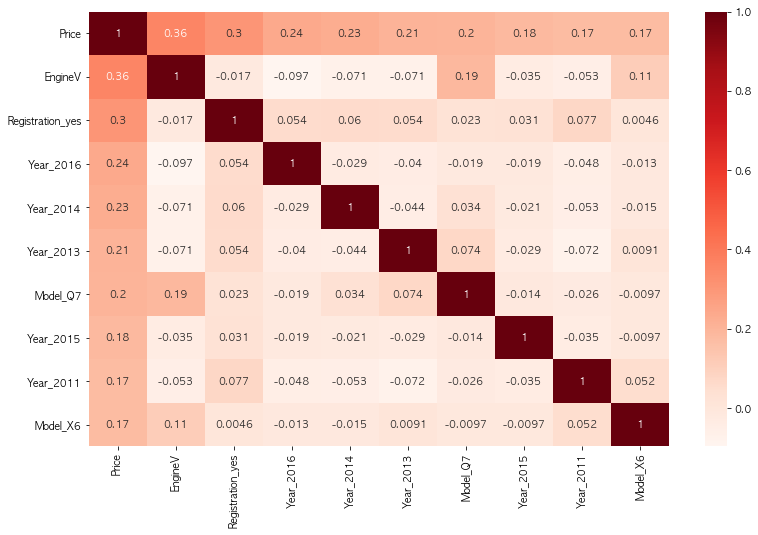

In [236]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(drop_set_df1[lista].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### simpleimputer 방식

In [237]:
simple_set_df1.corr()['Price'].sort_values(axis=0 ,ascending=False).iloc[1:10]

EngineV                     0.340585
Registration_yes            0.310848
Year_2016                   0.231326
Year_2014                   0.214238
Model_Q7                    0.199610
Year_2013                   0.191934
Year_2015                   0.184198
Model_Land Cruiser Prado    0.167082
Year_2011                   0.166054
Name: Price, dtype: float64

In [238]:
lista = [i for i in simple_set_df1.corr()['Price'].sort_values(axis=0 ,ascending=False).index][:10]

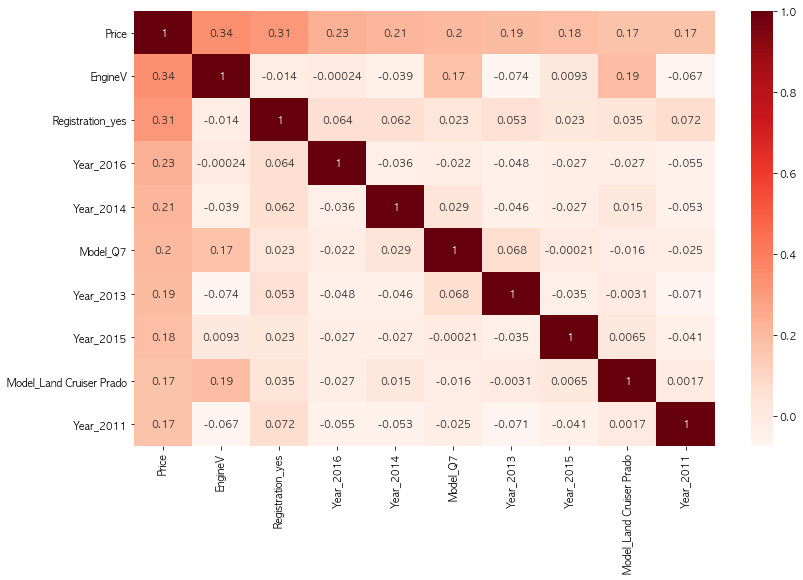

In [239]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(simple_set_df1[lista].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

#### IterativeImputer 방식

In [240]:
itera_set_df1.corr()['Price'].sort_values(axis=0 ,ascending=False).iloc[1:10]

EngineV             0.339775
Registration_yes    0.297724
Year_2016           0.240329
Year_2013           0.238024
Year_2014           0.229198
Year_2015           0.210608
Model_X6            0.200902
Model_Q7            0.189818
Year_2011           0.152902
Name: Price, dtype: float64

In [241]:
lista = [i for i in itera_set_df1.corr()['Price'].sort_values(axis=0 ,ascending=False).index][:10]

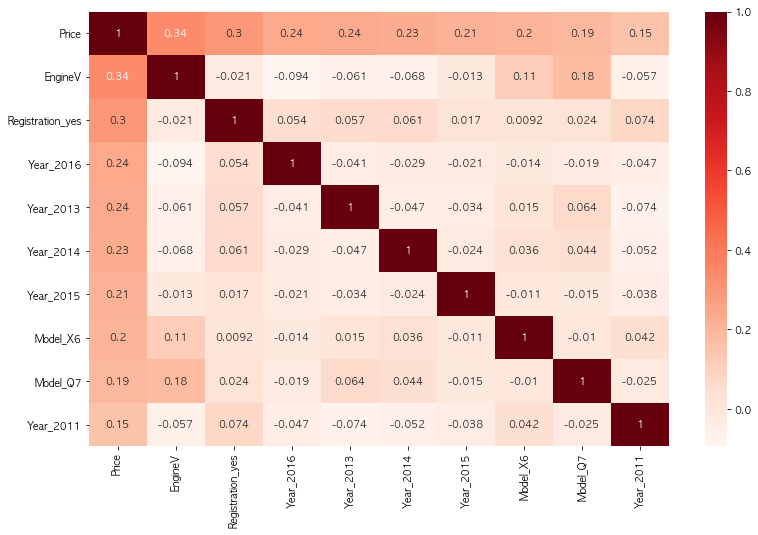

In [242]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(itera_set_df1[lista].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

---

# 4. Standard Scaler 적용

In [300]:
for d,i in enumerate([drop_set_df1,simple_set_df1,itera_set_df1]):
    
    globals()['st_df_{}'.format(d)] = i.copy()
    
    scaler = StandardScaler()
    sd = scaler.fit_transform( globals()['st_df_{}'.format(d)][['Mileage','EngineV']])
    
    globals()['st_df_{}'.format(d)]['Mileage'] = sd[:,0]
    globals()['st_df_{}'.format(d)]['EngineV'] = sd[:,1]
    
    col_name =  globals()['st_df_{}'.format(d)].columns
    
    globals()['df_data_{}'.format(d)] =  globals()['st_df_{}'.format(d)][col_name[1:]]
    globals()['df_target_{}'.format(d)] = pd.DataFrame(data= globals()['st_df_{}'.format(d)][col_name[0]])

---

# 5. OLS

In [301]:
def OLS_score(target,data):
    model1 = sm.OLS(target,data).fit()
    
    print(' f-statistic : {} \n adj-R : {} \n durbin_watson : {} \n'.format(model1.fvalue,model1.rsquared_adj,durbin_watson(model1.resid)))
    
    return model1

In [302]:
def P_value_over(df,model):
    drop_column = []
    for i in df:
        if(model.pvalues.loc[i]>= 0.05):
            drop_column.append(i)
            
    print('P-value > 0.05 : {} \n'.format(drop_column))
    return drop_column

In [303]:
def VIF_score(df):
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns    
    return vif

In [304]:
def max_VIF(df,n):
    
    globals()['VIF_{}'.format(n)] = VIF_score(df)

    max = 0.0
    index = 0

    for d,i in enumerate(globals()['VIF_{}'.format(n)]['VIF Factor']):
        if(max < i):
            max = i
            index = d
    


    if(max >10):
        return  globals()['VIF_{}'.format(n)]['features'].iloc[index]

    else:
        return 'none'
        

In [305]:
def running_OLS3(target,i):
    
    globals()['del_column_{}'.format(i)] = []
    count = 1
    
    while(True):
        print('\n {} 번째 OLS 입니다. \n'.format(count))
        
        
        globals()['model_{}'.format(count)] = OLS_score(target,globals()['df_data_{}'.format(i)])
        globals()['P_{}'.format(count)] = P_value_over(globals()['df_data_{}'.format(i)],globals()['model_{}'.format(count)])
        
        
        if(len(globals()['P_{}'.format(count)]) >=1):
            globals()['del_column_{}'.format(i)]+=globals()['P_{}'.format(count)]
            globals()['df_data_{}'.format(i)] = globals()['df_data_{}'.format(i)].drop(globals()['P_{}'.format(count)],axis=1)
            
            
            
            if(max_VIF(globals()['df_data_{}'.format(i)],i) != 'none'):
                drop_col = max_VIF(globals()['df_data_{}'.format(i)],i)
                globals()['del_column_{}'.format(i)].append(drop_col)

                print('삭제될 vif >10 존재 \n삭제될 열 이름 {} \n삭제될 열 vif 값 : {}\n'.format(drop_col,globals()['VIF_{}'.format(i)].loc[globals()['VIF_{}'.format(i)]['features']== drop_col,'VIF Factor'].values[0]))

                print('-'*200)
                globals()['df_data_{}'.format(i)] = globals()['df_data_{}'.format(i)].drop(drop_col,axis=1)
                count += 1
            
            else:
                print('삭제될 vif > 10 없음 \n')
                print('-'*200)
                count+=1
                

        else:
            if(max_VIF(globals()['df_data_{}'.format(i)],i) != 'none'):
                drop_col = max_VIF(globals()['df_data_{}'.format(i)],i)
                globals()['del_column_{}'.format(i)].append(drop_col)
                print('삭제될 vif >10 존재 \n삭제될 열 이름 {} \n삭제될 열 vif 값 : {}\n'.format(drop_col,globals()['VIF_{}'.format(i)].loc[globals()['VIF_{}'.format(i)]['features']== drop_col,'VIF Factor'].values[0]))

                print('-'*200)
                globals()['df_data_{}'.format(i)] = globals()['df_data_{}'.format(i)].drop(drop_col,axis=1)
                count += 1
                
            else:
                
                print('삭제될 P>0.05 없음 \n')
                print('삭제될 vif > 10 없음 \n')
                print('-'*200)
                print('최종 모델 score \n')
                globals()['model_{}'.format(count)] = OLS_score(target,globals()['df_data_{}'.format(i)])
                break

        
    
    return globals()['model_{}'.format(count)]

&nbsp;

## 5-1. OLS 모델 학습

In [306]:
testa = ['dropna','simpleinputer','IterativeImputer']

for i in range(3):
    globals()['final_model_{}'.format(i)] = running_OLS3(globals()['df_target_{}'.format(i)],i)
    print('*'*96 + ' {}끝 '.format(testa[i]) + '*'*96)


 1 번째 OLS 입니다. 

 f-statistic : 67.45053785343552 
 adj-R : 0.8538789355521168 
 durbin_watson : 2.022953373979648 

P-value > 0.05 : ['Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Body_hatch', 'Body_other', 'Model_11', 'Model_116', 'Model_118', 'Model_120', 'Model_190', 'Model_200', 'Model_210', 'Model_220', 'Model_230', 'Model_250', 'Model_300', 'Model_324', 'Model_5', 'Model_5 Series', 'Model_524', 'Model_540', 'Model_740', 'Model_745', 'Model_9', 'Model_A 140', 'Model_A 150', 'Model_A 170', 'Model_A 180', 'Model_ASX', 'Model_Amarok', 'Model_Avalon', 'Model_B 170', 'Model_B 180', 'Model_B 200', 'Model_B-Class Electric Drive', 'Model_Beetle', 'Model_Bora', 'Model_CL 55 AMG', 'Model_CLC 180', 'Model_CLC 200', 'Model_CLK 200', 'Model_CLK 230', 'Model_CLK 240', 'Model_CLK 430', 'Model_CLS 400', 'Model_CLS 500', 'Model_CLS 63 AMG', 'Model_Captur', 'Model_Caravelle', 'Model_Carina', 'Model_Carisma', 'Model_Celica', 'Model_Clio', 'Model_Colt',

&nbsp;

## 5-1. model 스코어 확인

&nbsp;

#### drop 모델
#### f-statistic : 281.4572063313266 
#### adj-R : 0.9117560523711995 
#### durbin_watson : 1.9670355623933782 

&nbsp;

#### simpleimputer 모델
#### f-statistic : 233.38464751891877 
#### adj-R : 0.88141082138558 
#### durbin_watson : 2.007748143662202 

&nbsp;

#### IterativeImputer 모델
#### f-statistic : 245.51795851704566 
#### adj-R : 0.9035926867838932 
#### durbin_watson : 2.0286606557037494 

&nbsp;

## 5-2. OLS 분석

In [307]:

for i in range(len(testa)):
    print(testa[i])
    print('삭제된 열의 갯수 : {} \n최종적으로 남은 열의 갯수 : {} \n\n'.format(len(globals()['del_column_{}'.format(i)]),len(globals()['df_data_{}'.format(i)].columns)))

dropna
삭제된 열의 갯수 : 234 
최종적으로 남은 열의 갯수 : 132 


simpleinputer
삭제된 열의 갯수 : 240 
최종적으로 남은 열의 갯수 : 126 


IterativeImputer
삭제된 열의 갯수 : 218 
최종적으로 남은 열의 갯수 : 148 




&nbsp;

### 각 모델의 summary 출력

In [308]:
for i in range(3):
    print(testa[i])
    print(globals()['final_model_{}'.format(i)].summary())
    print()
    print()
    print('-'*200)
    

dropna
                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              281.5
Date:                Wed, 11 Aug 2021   Prob (F-statistic):                        0.00
Time:                        12:58:57   Log-Likelihood:                         -35723.
No. Observations:                3583   AIC:                                  7.171e+04
Df Residuals:                    3451   BIC:                                  7.253e+04
Df Model:                         132                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------

&nbsp;

### 최종 선택된 변수들중 상관관계 높은순서대로 10개 상관관계 시각화

In [309]:
for i in range(len(testa)):
    globals()['df_val_{}'.format(i)] = globals()['df_data_{}'.format(i)].copy()
    globals()['df_val_{}'.format(i)]['Price'] = globals()['df_target_{}'.format(i)]
    globals()['top_10_{}'.format(i)] = [i for i in globals()['df_val_{}'.format(i)].corr()['Price'].sort_values(axis=0 ,ascending=False).index][:10]

&nbsp;

### dropna

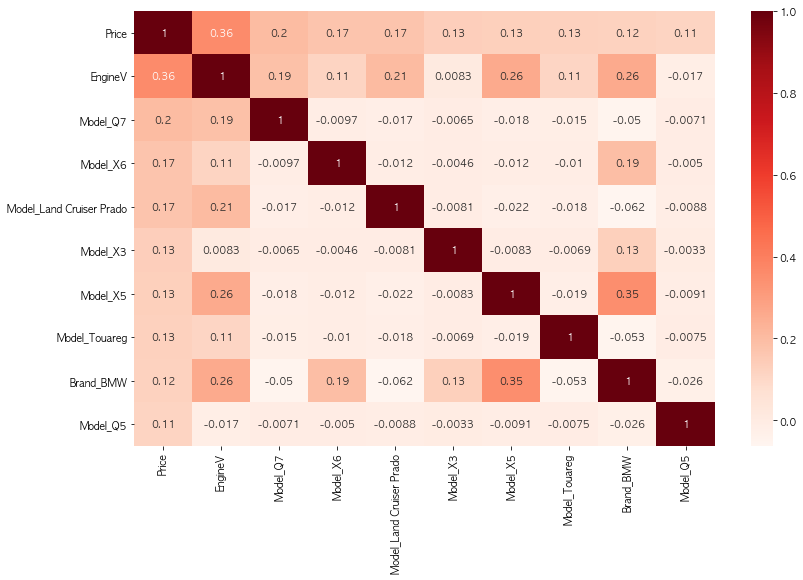

In [310]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(df_val_0[top_10_0].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

### simpleinputer 

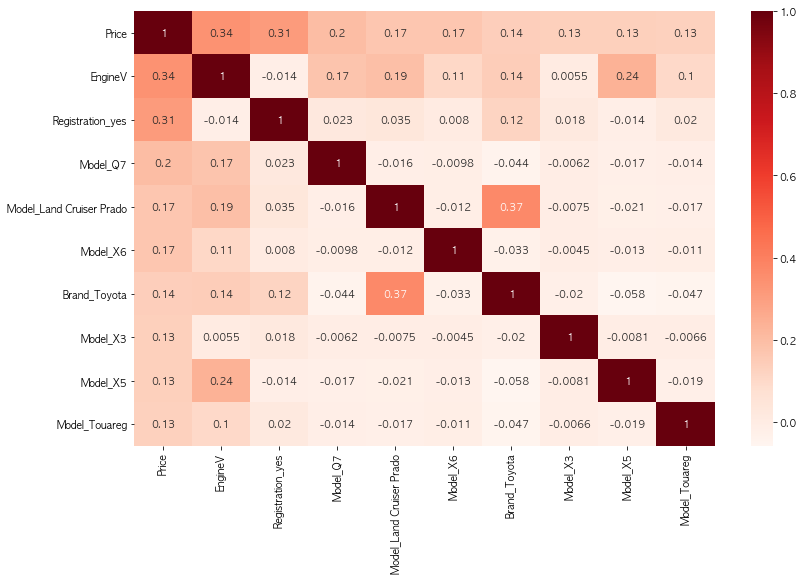

In [311]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(df_val_1[top_10_1].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

### IterativeImputer

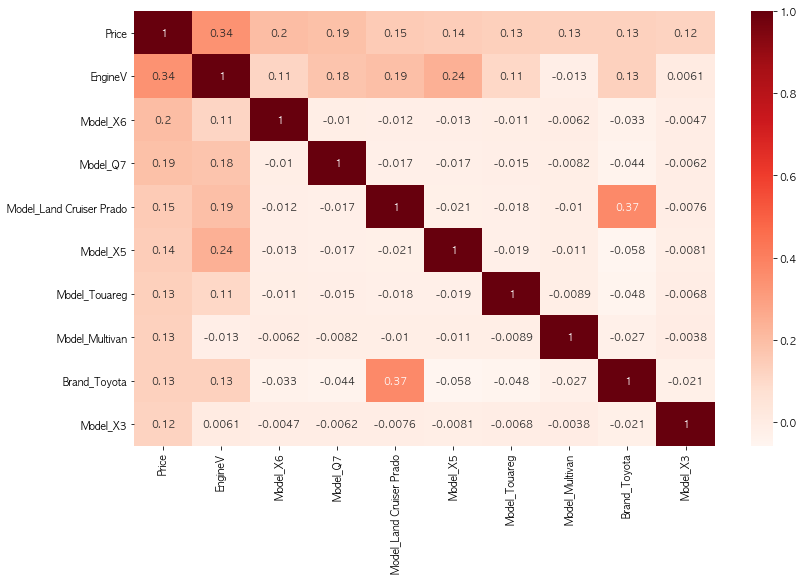

In [312]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(df_val_2[top_10_2].corr(),annot=True,cmap='Reds')
plt.show()

## 5-3. 유의하지 않은 변수의 이유 찾기

In [313]:
for i in range(len(testa)):
    globals()['dell_{}'.format(i)] = globals()['del_column_{}'.format(i)].copy()
    globals()['dell_{}'.format(i)].append('Price')
    globals()['down_10_{}'.format(i)] = [i for i in globals()['st_df_{}'.format(i)][globals()['dell_{}'.format(i)]].corr()['Price'].sort_values(axis=0 ,ascending=False).index][:10]

&nbsp;

### dropna

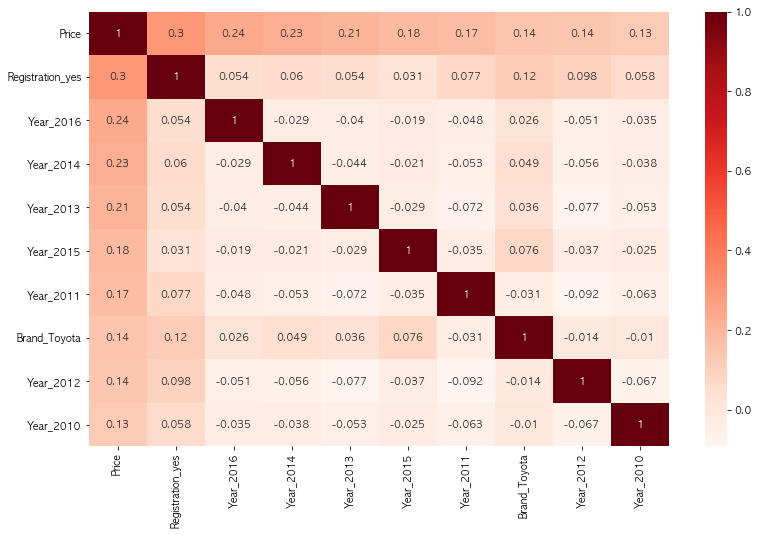

In [314]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(st_df_0[down_10_0].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

### simpleinputer

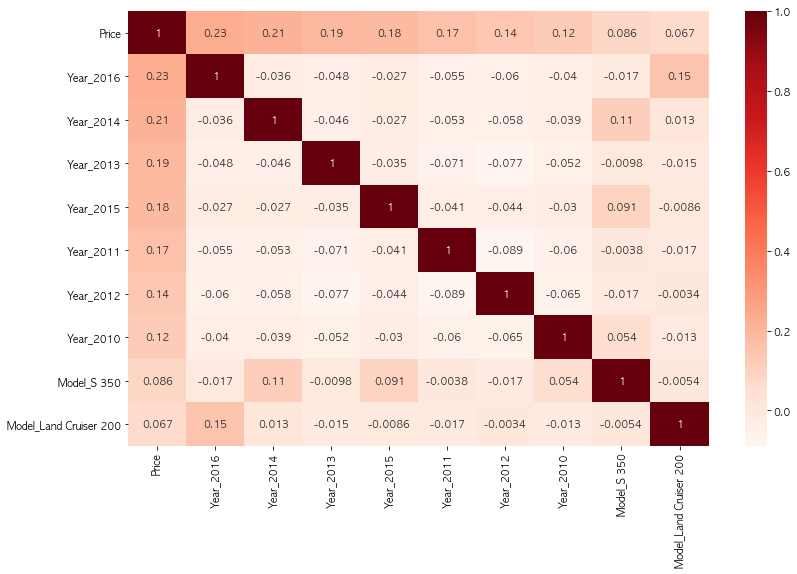

In [315]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(st_df_1[down_10_1].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

### IterativeImputer

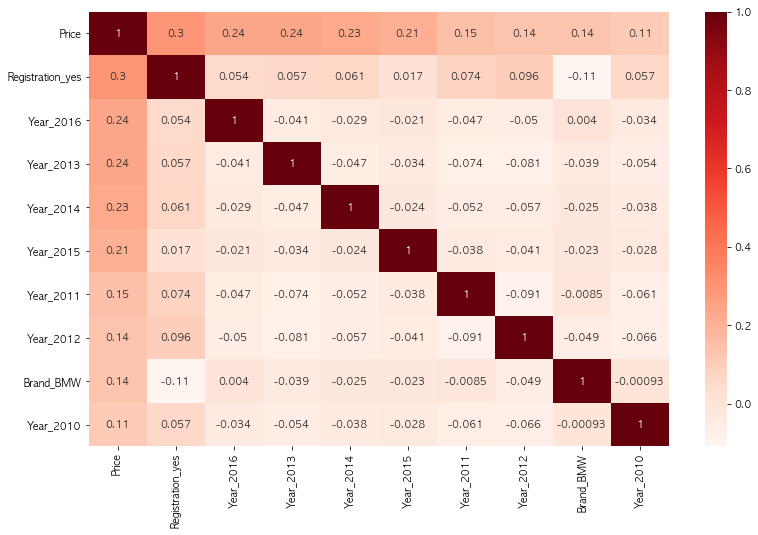

In [316]:
plot_size = (13, 8)
fig, ax = pyplot.subplots(figsize=plot_size)
sns.heatmap(st_df_2[down_10_2].corr(),annot=True,cmap='Reds')
plt.show()

&nbsp;

## 5-4. EngineV만 그래프로 확인

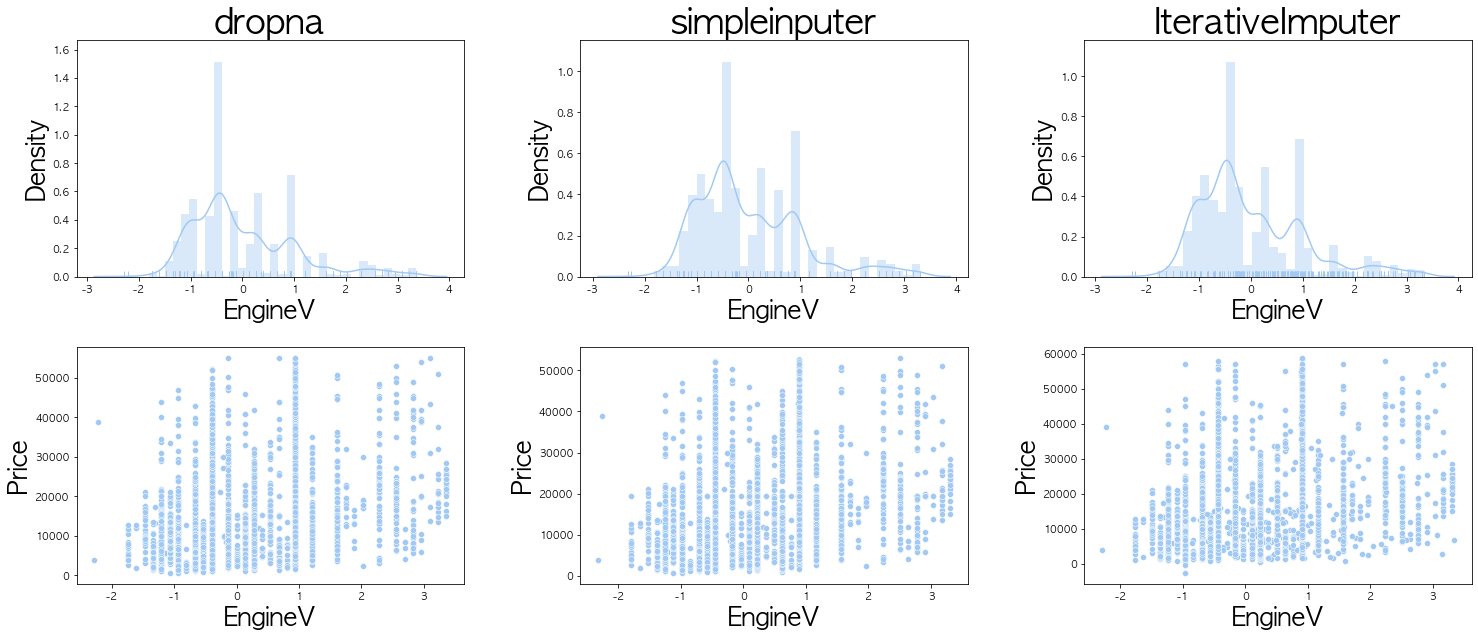

In [317]:
fig, axes = plt.subplots(2,3,figsize=(25, 10))
plt.subplots_adjust(wspace=0.3, hspace = 0.3)

for i in range(3):
    E_P_distplot  = sns.distplot(globals()['st_df_{}'.format(i)]['EngineV'],kde=True, rug=True , ax=axes[0,i])
    E_P_distplot.set_title(testa[i], fontsize=35)
    E_P_distplot.set_xlabel('EngineV',fontsize=25)
    E_P_distplot.set_ylabel('Density',fontsize=25)
    
    E_P_scatterplot = sns.scatterplot(x = 'EngineV',y='Price' ,data = globals()['st_df_{}'.format(i)] , ax=axes[1,i])
    E_P_scatterplot.set_xlabel('EngineV',fontsize=25)
    E_P_scatterplot.set_ylabel('Price',fontsize=25)

plt.show()

&nbsp;

## 5-5. 보고서 만들기

In [318]:
for i in range(3):
    results_as_html = globals()['final_model_{}'.format(i)].summary().tables[1].as_html()
    
    globals()['variable_report_{}'.format(i)] = pd.read_html(results_as_html, header=0, index_col=0)[0]
    
    results1 = globals()['final_model_{}'.format(i)].summary().tables[0].as_html()
    report1 = pd.read_html(results1)[0]

    results2 = globals()['final_model_{}'.format(i)].summary().tables[2].as_html()
    report2 = pd.read_html(results2)[0]
    
    globals()['score_report_{}'.format(i)] = pd.concat([report1,pd.DataFrame(['-','-','-','-']).transpose(),report2])
    
    globals()['variable_report_{}'.format(i)].to_csv( testa[i] + '_variable_report.csv')
    globals()['score_report_{}'.format(i)].to_csv(testa[i] + '_score_report.csv')

&nbsp;

### dropna

In [319]:
variable_report_0

coef   std err       t  P>|t|     [0.025     0.975]
Mileage      -2307.9756   131.606 -17.537  0.000  -2566.008  -2049.943
EngineV       1413.4255   157.988   8.946  0.000   1103.667   1723.184
Year_1978   -17770.0000  5298.196  -3.354  0.001 -28200.000  -7381.980
Year_1979   -17710.0000  3072.647  -5.764  0.000 -23700.000 -11700.000
Year_1980   -17850.0000  3104.182  -5.752  0.000 -23900.000 -11800.000
...                 ...       ...     ...    ...        ...        ...
Model_X5 M   16740.0000  3759.746   4.453  0.000   9371.106  24100.000
Model_X6     13160.0000  1173.057  11.223  0.000  10900.000  15500.000
Model_X6 M   17140.0000  5306.481   3.230  0.001   6733.156  27500.000
Model_Yaris  16030.0000  1462.729  10.957  0.000  13200.000  18900.000
Model_Z4      8714.6123  2403.639   3.626  0.000   4001.914  13400.000

[132 rows x 6 columns]

In [320]:
score_report_0

0                 1                             2         3
0     Dep. Variable:             Price       R-squared (uncentered):     0.915
1             Model:               OLS  Adj. R-squared (uncentered):     0.912
2            Method:     Least Squares                  F-statistic:     281.5
3              Date:  Wed, 11 Aug 2021           Prob (F-statistic):       0.0
4              Time:          12:59:29               Log-Likelihood:  -35723.0
5  No. Observations:              3583                          AIC:   71710.0
6      Df Residuals:              3451                          BIC:   72530.0
7          Df Model:               132                           NaN       NaN
8   Covariance Type:         nonrobust                           NaN       NaN
0                  -                 -                             -         -
0           Omnibus:           989.442                Durbin-Watson:     1.967
1     Prob(Omnibus):               0.0             Jarque-Bera (JB):  5360.962
2              Skew:             1.207                     Prob(JB):       0.0
3          Kurtosis:             8.485                     Cond. No.      67.1

&nbsp;

### simpleinputer

In [321]:
variable_report_1

coef   std err       t  P>|t|     [0.025     0.975]
Mileage      -2238.6861   144.572 -15.485  0.000  -2522.134  -1955.238
EngineV       1018.2096   151.922   6.702  0.000    720.352   1316.067
Year_1979   -13480.0000  3514.777  -3.835  0.000 -20400.000  -6589.523
Year_1980   -14150.0000  3551.387  -3.984  0.000 -21100.000  -7185.764
Year_1982   -14870.0000  6070.502  -2.449  0.014 -26800.000  -2967.823
...                 ...       ...     ...    ...        ...        ...
Model_X5      6525.3495   770.442   8.470  0.000   5014.823   8035.876
Model_X6     12760.0000  1221.463  10.445  0.000  10400.000  15200.000
Model_X6 M   20380.0000  6084.670   3.349  0.001   8447.085  32300.000
Model_Yaris  -7123.6507  1701.426  -4.187  0.000 -10500.000  -3787.840
Model_Z4      8681.0515  2744.275   3.163  0.002   3300.636  14100.000

[126 rows x 6 columns]

In [322]:
score_report_1

0                 1                             2  \
0     Dep. Variable:             Price       R-squared (uncentered):   
1             Model:               OLS  Adj. R-squared (uncentered):   
2            Method:     Least Squares                  F-statistic:   
3              Date:  Wed, 11 Aug 2021           Prob (F-statistic):   
4              Time:          12:59:29               Log-Likelihood:   
5  No. Observations:              3877                          AIC:   
6      Df Residuals:              3753                          BIC:   
7          Df Model:               124                           NaN   
8   Covariance Type:         nonrobust                           NaN   
0                  -                 -                             -   
0           Omnibus:            798.87                Durbin-Watson:   
1     Prob(Omnibus):               0.0             Jarque-Bera (JB):   
2              Skew:             1.059                     Prob(JB):   
3          Kurtosis:             6.218                     Cond. No.   

                      3  
0                 0.885  
1                 0.881  
2                 233.4  
3                   0.0  
4              -39204.0  
5               78660.0  
6               79430.0  
7                   NaN  
8                   NaN  
0                     -  
0                 2.008  
1              2396.667  
2                   0.0  
3  187000000000000000.0

&nbsp;

### IterativeImputer

In [323]:
variable_report_2

coef   std err       t  P>|t|     [0.025     0.975]
Mileage      -2399.8280   139.482 -17.205  0.000  -2673.298  -2126.358
EngineV       1631.1908   160.167  10.184  0.000   1317.166   1945.215
Year_1978   -17410.0000  5715.394  -3.047  0.002 -28600.000  -6209.025
Year_1979   -18210.0000  3307.394  -5.506  0.000 -24700.000 -11700.000
Year_1980   -17640.0000  3338.199  -5.285  0.000 -24200.000 -11100.000
...                 ...       ...     ...    ...        ...        ...
Model_X5 M   46560.0000  2855.623  16.306  0.000  41000.000  52200.000
Model_X6     39010.0000  1099.304  35.483  0.000  36900.000  41200.000
Model_X6 M   39760.0000  5711.619   6.961  0.000  28600.000  51000.000
Model_Yaris  -5990.3218  1601.802  -3.740  0.000  -9130.827  -2849.817
Model_Z4     32120.0000  2569.179  12.502  0.000  27100.000  37200.000

[148 rows x 6 columns]

In [324]:
score_report_2

0                 1                             2  \
0     Dep. Variable:             Price       R-squared (uncentered):   
1             Model:               OLS  Adj. R-squared (uncentered):   
2            Method:     Least Squares                  F-statistic:   
3              Date:  Wed, 11 Aug 2021           Prob (F-statistic):   
4              Time:          12:59:29               Log-Likelihood:   
5  No. Observations:              3835                          AIC:   
6      Df Residuals:              3688                          BIC:   
7          Df Model:               147                           NaN   
8   Covariance Type:         nonrobust                           NaN   
0                  -                 -                             -   
0           Omnibus:           938.181                Durbin-Watson:   
1     Prob(Omnibus):               0.0             Jarque-Bera (JB):   
2              Skew:             1.094                     Prob(JB):   
3          Kurtosis:             7.844                     Cond. No.   

                    3  
0               0.907  
1               0.904  
2               245.5  
3                 0.0  
4            -38524.0  
5             77340.0  
6             78260.0  
7                 NaN  
8                 NaN  
0                   -  
0               2.029  
1            4515.012  
2                 0.0  
3  2250000000000000.0

&nbsp;

### 5-6. 예측값 저장하기

In [325]:
for i in range(3):
    globals()['y_pred_{}'.format(i)] = pd.DataFrame(data = globals()['final_model_{}'.format(i)].predict())
    globals()['y_pred_{}'.format(i)].columns = ['Pred']
    globals()['y_pred_{}'.format(i)].to_csv(testa[i]+'OLS_pred.csv')

&nbsp;

### dropna

In [326]:
y_pred_0

Pred
0      5202.446655
1     26692.517035
2     22075.095366
3     12747.098490
4     11653.356187
...            ...
3578  14160.967293
3579  17852.126826
3580  21200.861805
3581  12363.365096
3582  16222.802991

[3583 rows x 1 columns]

&nbsp;

### simpleinputer

In [327]:
y_pred_1

Pred
0      6460.385754
1     27897.421828
2     19112.699019
3     17501.926317
4     11829.147269
...            ...
3872  15272.498016
3873  27489.779580
3874  13025.925731
3875  16992.345190
3876  15526.699442

[3877 rows x 1 columns]

&nbsp;

### IterativeImputer

In [328]:
y_pred_2

Pred
0      3765.878843
1     26717.594986
2     22196.188399
3     12380.527431
4     12043.079699
...            ...
3830  18242.496893
3831  22046.147410
3832  10112.198559
3833  18917.681158
3834  16618.216398

[3835 rows x 1 columns]

&nbsp;

# 6. 평가

for i in range(3):
    print('{}방법 \nMAE : {} \nMSE : {} \nRMSE : {}\n'.format(testa[i],metrics.mean_absolute_error(globals()['df_target_{}'.format(i)], globals()['y_pred_{}'.format(i)]),metrics.mean_squared_error(globals()['df_target_{}'.format(i)], globals()['y_pred_{}'.format(i)]),np.sqrt(metrics.mean_squared_error(globals()['df_target_{}'.format(i)], globals()['y_pred_{}'.format(i)]))))

### 최종적인 평가로는 dropna를 쓴 결측치 방법이 성능이 더 좋은것을 확인할수 있다.